In [136]:
from itertools import chain
import pandas as pd
import numpy as np
from re import T
from sklearn.metrics import mean_squared_error
from math import sqrt
import markovify
id=0

############ load and digitize the data
data=pd.read_csv('/home/ebotian/MCM/tennis2.csv')

############

############# pre-process the data
    # fill nan with 0, and replace AD with 50
def pre_process(data):
    data = pd.get_dummies(data, columns=['winner_shot_type','serve_width','serve_depth','return_depth'])
    data = data.fillna(0)
    data = data.replace('AD', 50.0)
    #data['point_victor']=data["point_victor"].replace(2,0)
    #print(data.iloc[:,15])
    ###################################
    #for predict:
    conditions = [
        (data['server'] == 1) & (data['point_victor'] == 1),
        (data['server'] == 1) & (data['point_victor'] == 2),
        (data['server'] == 2) & (data['point_victor'] == 2),
        (data['server'] == 2) & (data['point_victor'] == 1)
    ]
    choices = ['P1_serve_win', 'P1_serve_lose', 'P2_serve_win', 'P2_serve_lose']
    data['state'] = np.select(conditions, choices, default='unknown')

    # split the data into different match
    grouped = dict(tuple(data.groupby(data['match_id'].ne(data['match_id'].shift()).cumsum())))

    # Rename the subdata
    subdata = {df['match_id'].iloc[0]: df for _, df in grouped.items()}

    # Create a new dataset from the first column, excluding duplicates
    match = pd.DataFrame(data.iloc[:, 0].drop_duplicates()).iloc[:,0].tolist()


    return subdata,match

subdata,match=pre_process(data)
#print(subdata[match[1]])
##############

def process_all_ids(subdata):
    for id in range(len(match)):
        index_array = subdata[match[id]][subdata[match[id]]['server'] == 2].index.values
#        subdata[match[id]].loc[index_array, 'point_victor'] = 1 - subdata[match[id]].loc[index_array, 'point_victor']
        target=pd.DataFrame(subdata[match[id]]["point_victor"])
        # Add the "elapsed_time" column to the "target" DataFrame
        subdata[match[id]]['elapsed_time'] = pd.to_timedelta(subdata[match[id]]['elapsed_time'])
        target.insert(0, 'elapsed_time', subdata[match[id]]['elapsed_time'])
        target['elapsed_time'] = target['elapsed_time'].dt.total_seconds()
        #subdata[match[id]]=subdata[match[id]].drop(columns=["point_victor"])
        features=subdata[match[id]].drop(columns=["point_victor"]).iloc[:,4:]

    return target,features,subdata,index_array

# Replace with your actual match ids
target,features,subdata,index_array=process_all_ids(subdata)
#print(subdata[match[1]])
##############
##############
#invert the victor when the server is 2 to get server_victor
#and after the prediction, we invert the victor again
# Get the index array


# Invert the values in the "point_victor" column for the specified rows

#print(index_array)
##############
# Calculate the time difference between consecutive rows
def get_average_interval(id, subdata):

    # Calculate the time difference between consecutive rows
    subdata[match[id]]['time_diff'] = subdata[match[id]]['elapsed_time'].diff()

    # Calculate the 5th and 95th percentiles
    lower_threshold = subdata[match[id]]['time_diff'].quantile(0.05)
    upper_threshold = subdata[match[id]]['time_diff'].quantile(0.95)

    # Exclude the top 5% and bottom 5% of periods
    filtered_diff = subdata[match[id]]['time_diff'][(subdata[match[id]]['time_diff'] > lower_threshold) & (subdata[match[id]]['time_diff'] < upper_threshold)]

    # Calculate the average of the remaining intervals
    average_interval = filtered_diff.mean()
    return average_interval.total_seconds()

average_interval_time=[]

for id in range(len(match)):
    average_interval_time.append(get_average_interval(id, subdata))

print(average_interval_time)

[43.78409, 40.59322, 39.725663, 37.31208, 39.0, 36.600706, 37.048543, 34.923076, 38.327956, 41.123674, 35.568493, 38.151639, 34.312252, 33.364197, 34.539772, 41.554794, 41.755, 41.395833, 34.773584, 34.866141, 40.021276, 35.890173, 31.554054, 37.925, 40.95238, 33.7, 37.491124, 42.31088, 37.605633, 47.819767, 47.070707]


In [144]:
import pandas as pd

def create_markov_chain(id, subdata):
  # Define extended states
  extended_states = [
    'P1_serve_win', 'P1_serve_lose',
    'P2_serve_win', 'P2_serve_lose'
  ]
  # Get the match data for the given id
  subdata[match[id]]["point_victor"]= subdata[match[id]]["point_victor"]

  # Initialize transition count matrix
  transition_counts = pd.DataFrame(0, index=extended_states, columns=extended_states)
  match_data=subdata[match[id]]

  # Iterate over the match data
  for i in range(1, len(match_data)):
    prev_point = match_data.iloc[i-1]
    curr_point = match_data.iloc[i]

    # Determine the state of the previous and current point
    prev_state = 'P{}_serve_{}'.format(prev_point['server'], 'win' if prev_point['point_victor'] == prev_point['server'] else 'lose')
    curr_state = 'P{}_serve_{}'.format(curr_point['server'], 'win' if curr_point['point_victor'] == curr_point['server'] else 'lose')

    # Update transition counts
    transition_counts.loc[prev_state, curr_state] += 1

  # Calculate transition probabilities
  transition_probabilities = transition_counts.div(transition_counts.sum(axis=1), axis=0)

  return transition_probabilities

# Initialize list to store transition matrices
transition_matrices = []

# Iterate over the range of the number of matches
for id in range(len(match)):
    # Create transition matrix for current match
    transition_matrix = create_markov_chain(id, subdata)

    # Add transition matrix to list
    transition_matrices.append(transition_matrix)

In [138]:
def create_markov_chain_p1p2(id, subdata):
  # Define states
  p1_states = ['P1_serve_win', 'P1_serve_lose']
  p2_states = ['P2_serve_win', 'P2_serve_lose']

  # Get the match data for the given id
  match_data = subdata[match[id]]
  match_data["point_victor"] = match_data["point_victor"]

  # Initialize transition count matrices
  p1_transition_counts = pd.DataFrame(0, index=p1_states, columns=p1_states)
  p2_transition_counts = pd.DataFrame(0, index=p2_states, columns=p2_states)

  # Iterate over the match data
  for i in range(1, len(match_data)):
    prev_point = match_data.iloc[i-1]
    curr_point = match_data.iloc[i]

    # Determine the state of the previous and current point
    prev_state = 'P{}_serve_{}'.format(prev_point['server'], 'win' if prev_point['point_victor'] == prev_point['server'] else 'lose')
    curr_state = 'P{}_serve_{}'.format(curr_point['server'], 'win' if curr_point['point_victor'] == curr_point['server'] else 'lose')

    # Update transition counts
    if prev_state in p1_states and curr_state in p1_states:
        p1_transition_counts.loc[prev_state, curr_state] += 1
    elif prev_state in p2_states and curr_state in p2_states:
        p2_transition_counts.loc[prev_state, curr_state] += 1

  # Calculate transition probabilities
  p1_transition_probabilities = p1_transition_counts.div(p1_transition_counts.sum(axis=1), axis=0)
  p2_transition_probabilities = p2_transition_counts.div(p2_transition_counts.sum(axis=1), axis=0)

  return p1_transition_probabilities, p2_transition_probabilities

# Initialize lists to store transition matrices
p1_transition_matrices = []
p2_transition_matrices = []

# Iterate over the range of the number of matches
for id in range(len(match)):
    # Create transition matrices for current match
    p1_transition_matrix, p2_transition_matrix = create_markov_chain_p1p2(id, subdata)

    # Add transition matrices to lists
    p1_transition_matrices.append(p1_transition_matrix)
    p2_transition_matrices.append(p2_transition_matrix)

In [139]:
print(subdata[match[id]].columns)

Index(['match_id', 'player1', 'player2', 'elapsed_time', 'set_no', 'game_no',
       'point_no', 'p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'p1_score',
       'p2_score', 'server', 'serve_no', 'point_victor', 'p1_points_won',
       'p2_points_won', 'game_victor', 'set_victor', 'p1_ace', 'p2_ace',
       'p1_winner', 'p2_winner', 'p1_double_fault', 'p2_double_fault',
       'p1_unf_err', 'p2_unf_err', 'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won',
       'p2_net_pt_won', 'p1_break_pt', 'p2_break_pt', 'p1_break_pt_won',
       'p2_break_pt_won', 'p1_break_pt_missed', 'p2_break_pt_missed',
       'p1_distance_run', 'p2_distance_run', 'rally_count', 'speed_mph',
       'winner_shot_type_0', 'winner_shot_type_B', 'winner_shot_type_F',
       'serve_width_B', 'serve_width_BC', 'serve_width_BW', 'serve_width_C',
       'serve_width_W', 'serve_depth_CTL', 'serve_depth_NCTL',
       'return_depth_D', 'return_depth_ND', 'state', 'time_diff'],
      dtype='object')


In [140]:
import numpy as np
from regex import P

def predict_state_sequence(transition_matrices, subdata, id, average_interval_time, max_time):
    # Define the states
    states = ['P1_serve_win', 'P1_serve_lose', 'P2_serve_win', 'P2_serve_lose']
    p1_states=['P1_serve_win', 'P1_serve_lose']
    p2_states=['P2_serve_win', 'P2_serve_lose']

    # Determine the initial state
    initial_state = subdata[match[id]].iloc[0]['state']  # Assuming 'state' column holds the state information

    # Calculate the number of steps
    num_steps = int(max_time / average_interval_time)

    # Generate the sequence of states
    state_sequence = [initial_state]
    current_state = initial_state
    current_matrix=transition_matrices[id]
    predict_steps=0

    while(num_steps>predict_steps):
        P1_match_win_counter=0
        P2_match_win_counter=0
        p1_point_win=[]
        p2_point_win=[]
        p1_point_win_counter=0
        p2_point_win_counter=0
        while(not(P1_match_win_counter>=3 or P2_match_win_counter>=3)):
            P1_set_win_counter=0
            P2_set_win_counter=0
            while(not ((P1_set_win_counter>=6 or P2_set_win_counter>=6)and abs(P1_set_win_counter-P2_set_win_counter)>=2)):
                if current_state == 'P1_serve_win' or current_state == 'P1_serve_lose':
                    serve=1
                else:
                    serve=2
                P1_game_win_counter = 0
                P2_game_win_counter = 0
                while (not((P1_game_win_counter >= 4 or P2_game_win_counter >= 4) and abs(P1_game_win_counter - P2_game_win_counter) >= 2)):
                    if serve==1:
                        game_matrix=p1_transition_matrices[id]
                        game_states=p1_states
                    else:
                        game_matrix=p2_transition_matrices[id]
                        game_states=p2_states
                    next_state = np.random.choice(game_states, p=game_matrix.loc[current_state].values)
                    if next_state == 'P1_serve_win' or next_state == 'P2_serve_lose':
                        P1_game_win_counter += 1
                        p1_point_win_counter+=1
                        p1_point_win.append(p1_point_win_counter)
                        p2_point_win.append(p2_point_win_counter)
                    elif next_state == 'P2_serve_win' or next_state == 'P1_serve_lose':
                        P2_game_win_counter += 1
                        p2_point_win_counter+=1
                        p1_point_win.append(p1_point_win_counter)
                        p2_point_win.append(p2_point_win_counter)
                    state_sequence.append(next_state)
                    current_state = next_state
                    predict_steps+=1
                serve=3-serve
                if(P1_game_win_counter>P2_game_win_counter):
                    P1_set_win_counter+=1
                else:
                    P2_set_win_counter+=1
            if(P1_set_win_counter>P2_set_win_counter):
                P1_match_win_counter+=1
            else:
                P2_match_win_counter+=1

    return p1_point_win,p2_point_win,P1_match_win_counter,P2_match_win_counter

# Usage:

max_time = 6*60*60  # Replace with the actual total time

# Initialize lists to store the predicted state sequences
p1_match_counter_list=[]
p2_match_counter_list=[]
predict_p1_point_win_list=[]
predict_p2_point_win_list=[]
# Iterate over the range of the number of matches
for id in range(len(match)):
    predict_p1_point_win,predict_p2_point_win,p1_match_counter,p2_match_counter  = predict_state_sequence(transition_matrices, subdata, id, average_interval_time[id], max_time)
    p1_match_counter_list.append(p1_match_counter)
    p2_match_counter_list.append(p2_match_counter)
    predict_p1_point_win_list.append(predict_p1_point_win)
    predict_p2_point_win_list.append(predict_p2_point_win)
#    state_sequence = predict_state_sequence(transition_matrices, subdata, id, average_interval_time[id], max_time)
#    #print(state_sequence)
print(p1_match_counter_list,p2_match_counter_list)
for id in range(len(match)):
    print(len(predict_p1_point_win_list[id]))
    print(len(predict_p2_point_win_list[id]))

[3, 0, 0, 3, 3, 1, 3, 0, 0, 1, 3, 1, 3, 0, 0, 0, 0, 3, 0, 3, 1, 0, 3, 3, 3, 0, 1, 0, 3, 0, 0] [0, 3, 3, 0, 0, 3, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 0, 0, 3, 3, 3, 0, 3, 3]
184
184
92
92
79
79
127
127
133
133
234
234
93
93
93
93
154
154
191
191
156
156
299
299
111
111
175
175
93
93
97
97
146
146
150
150
162
162
115
115
204
204
146
146
90
90
97
97
90
90
162
162
188
188
113
113
107
107
118
118
155
155


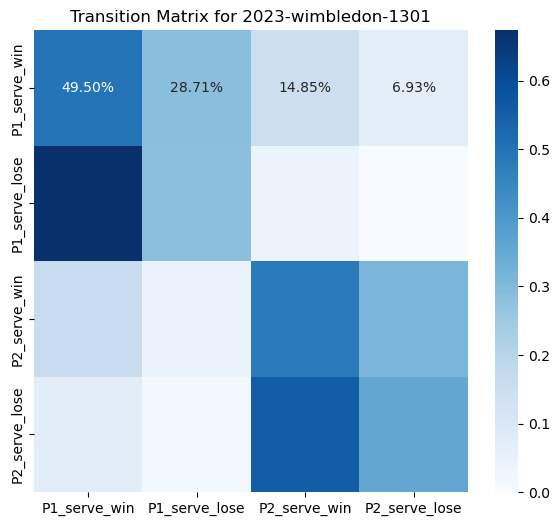

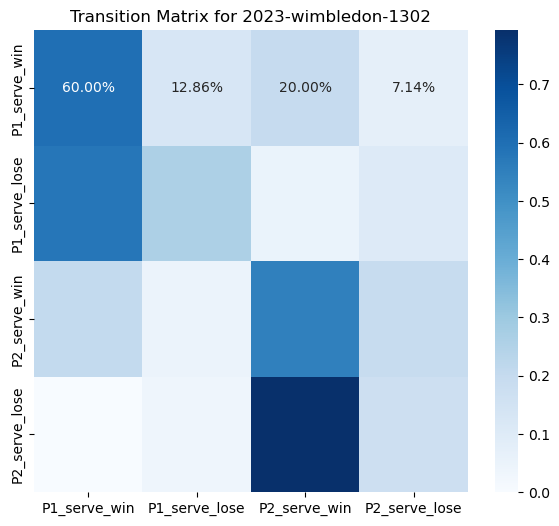

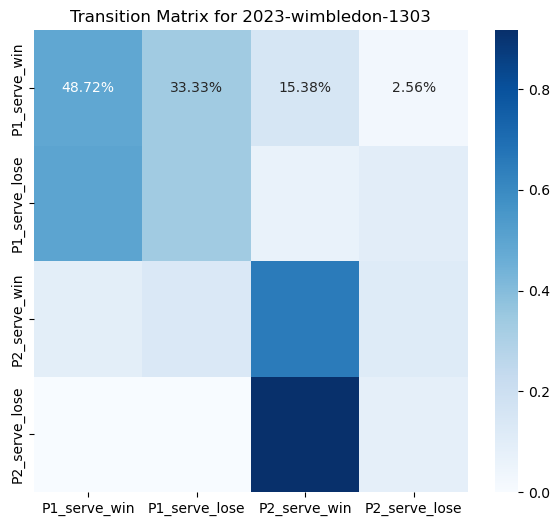

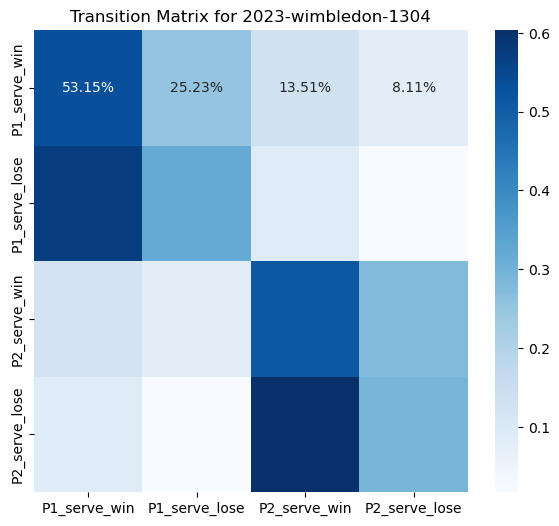

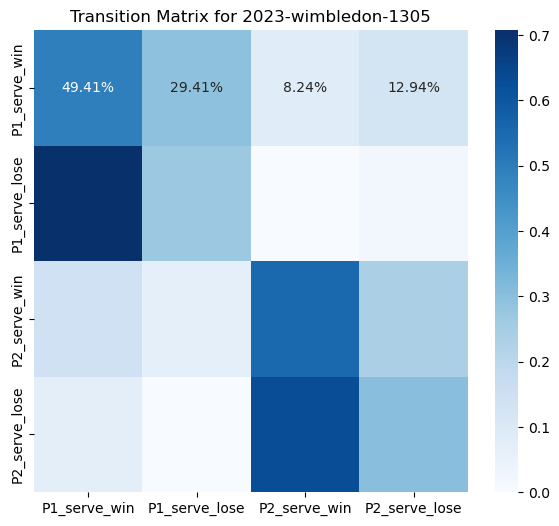

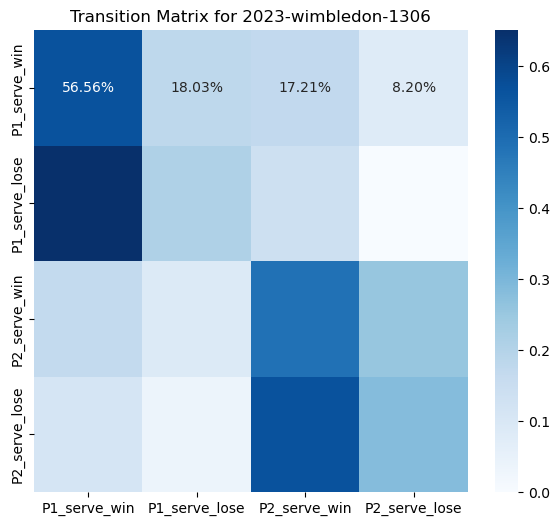

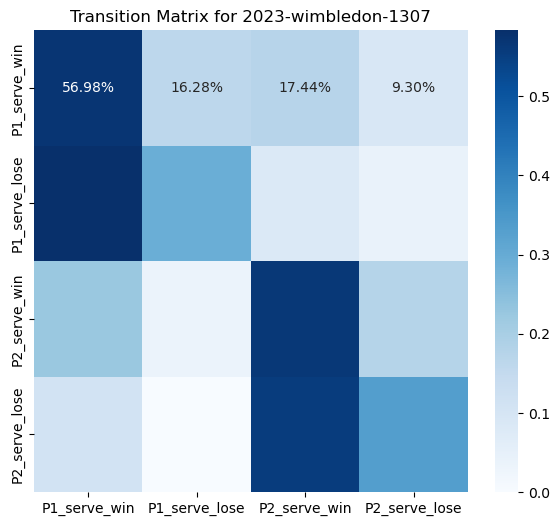

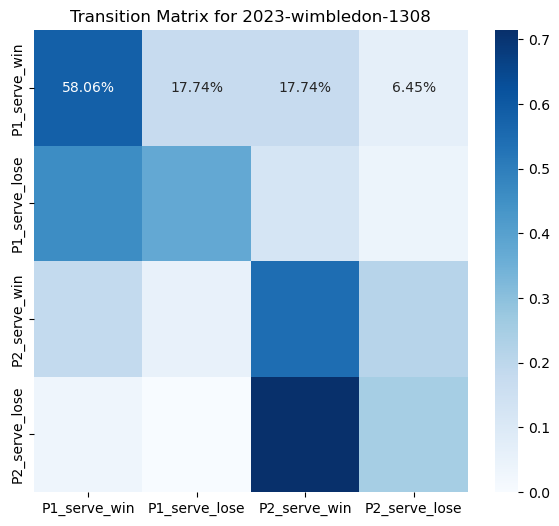

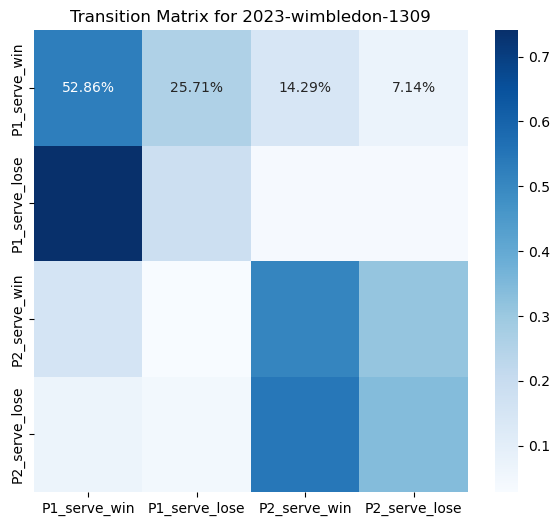

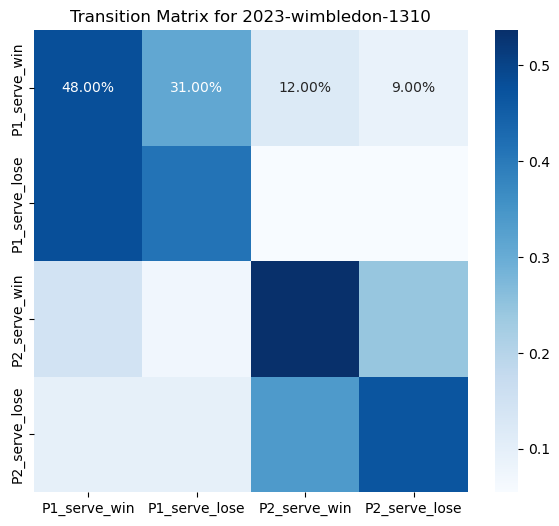

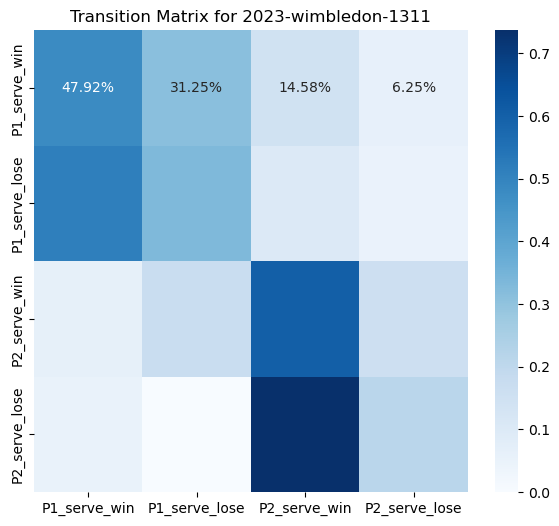

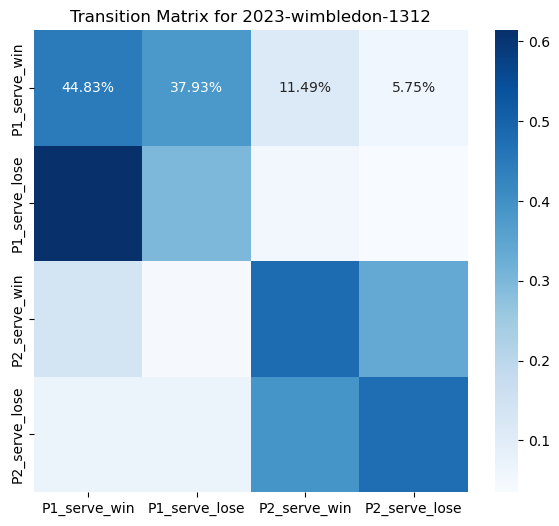

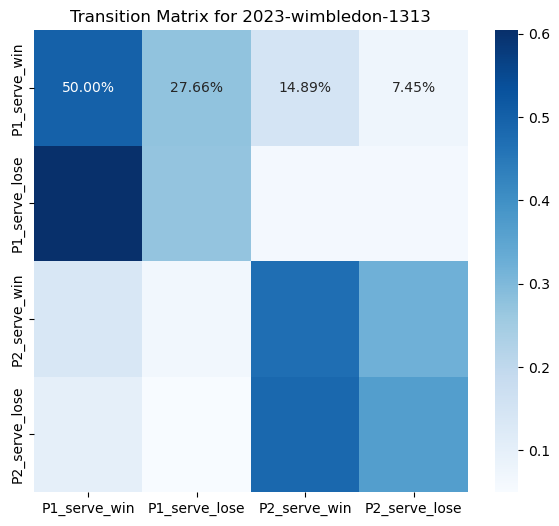

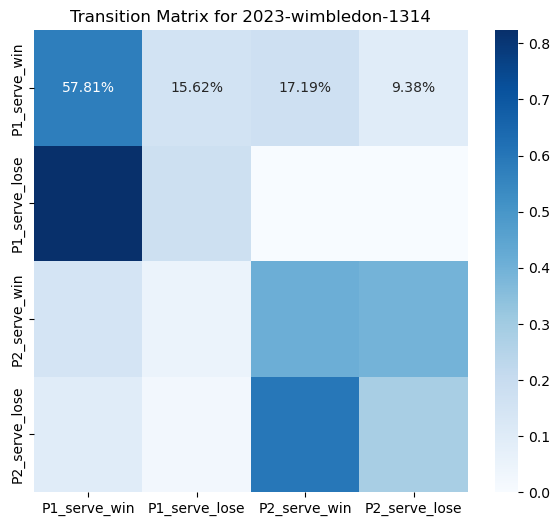

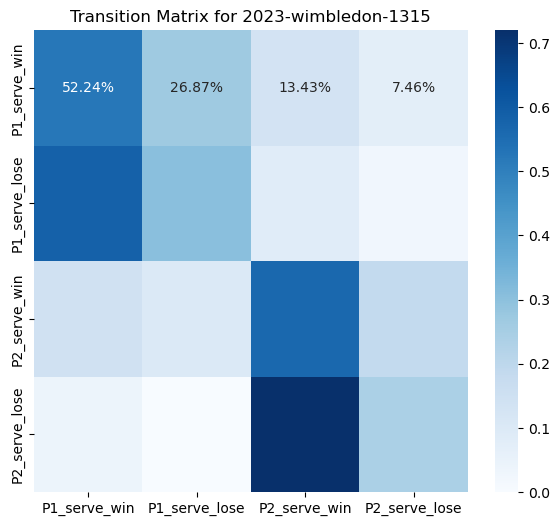

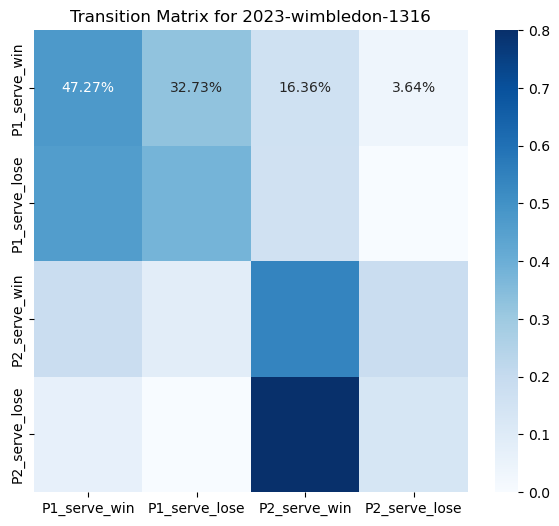

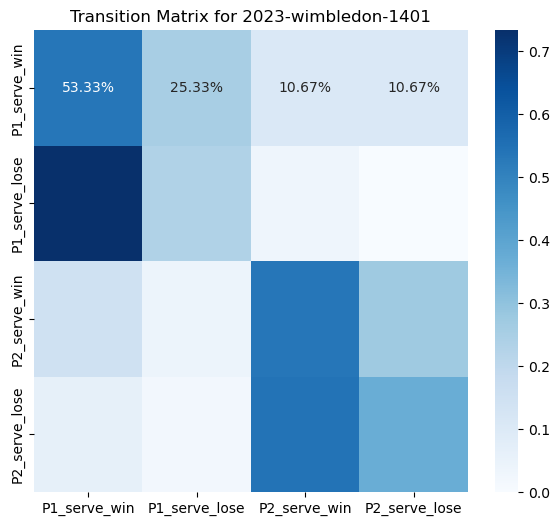

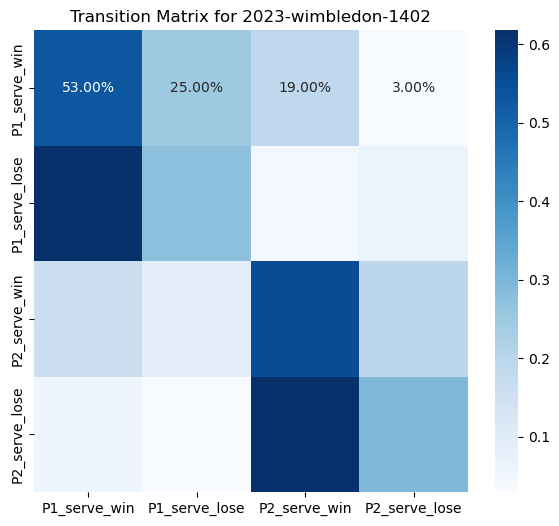

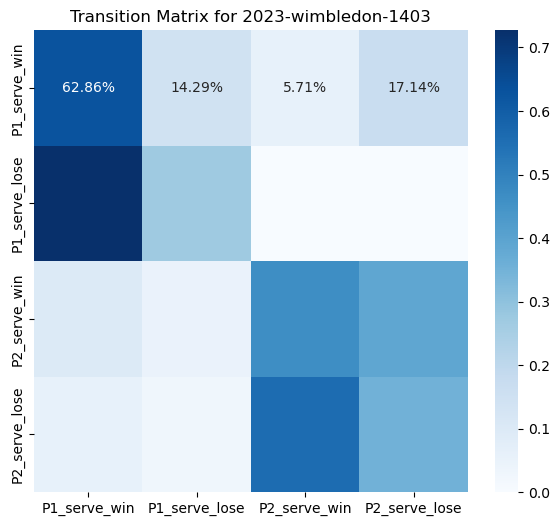

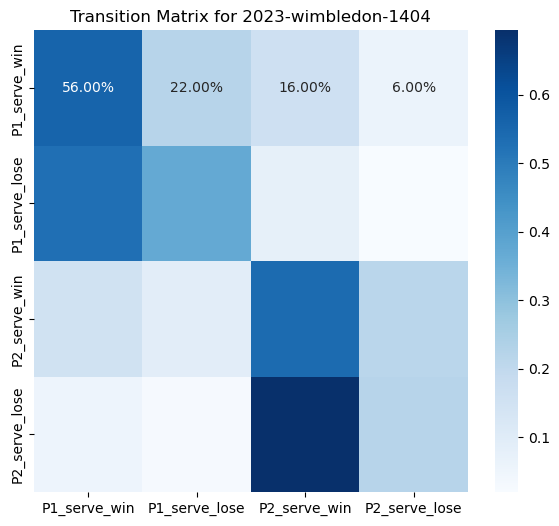

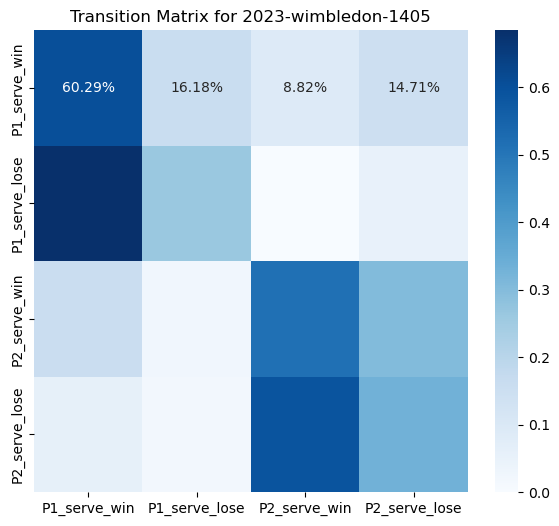

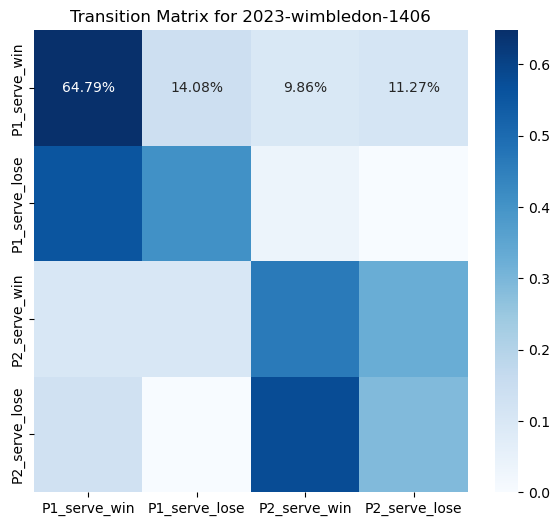

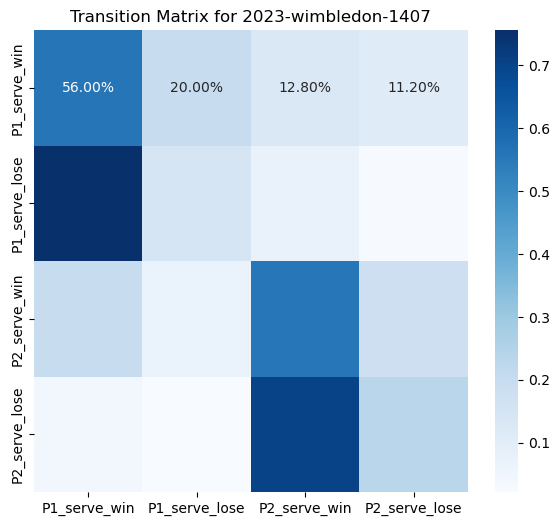

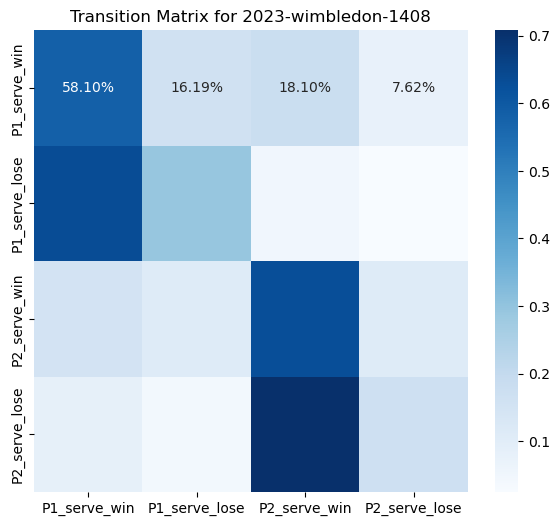

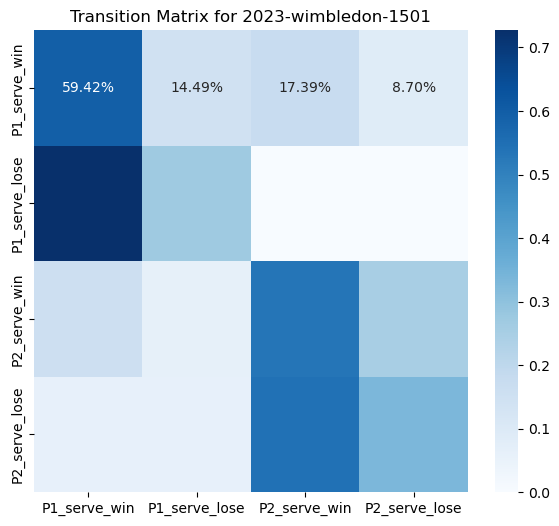

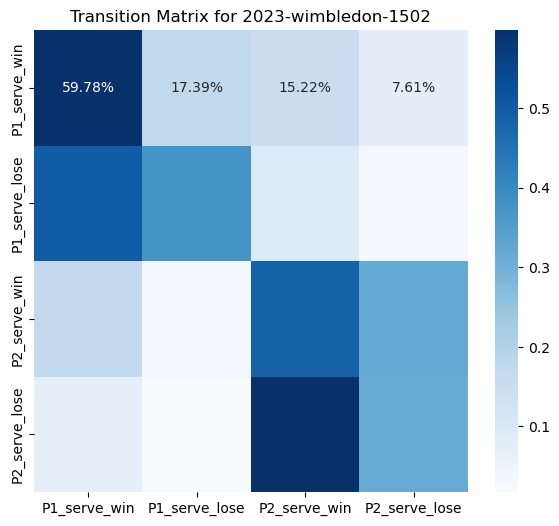

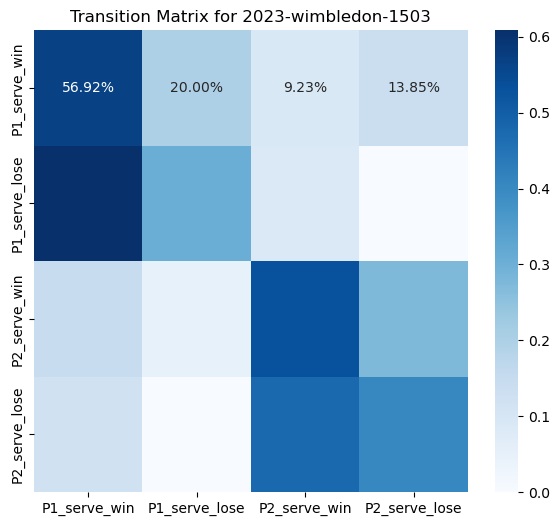

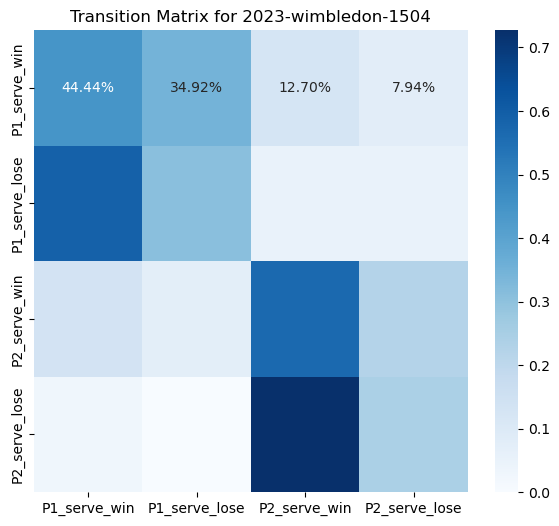

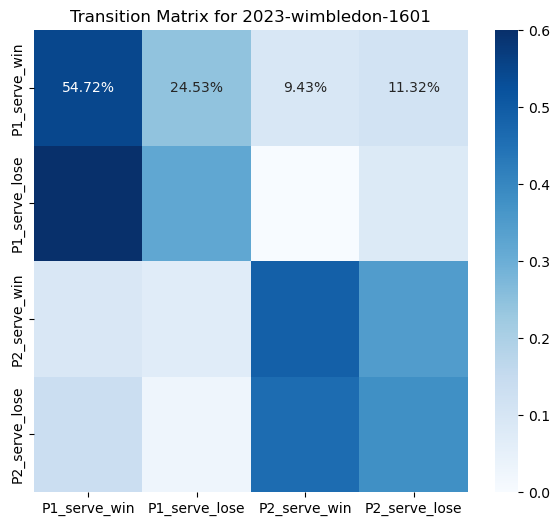

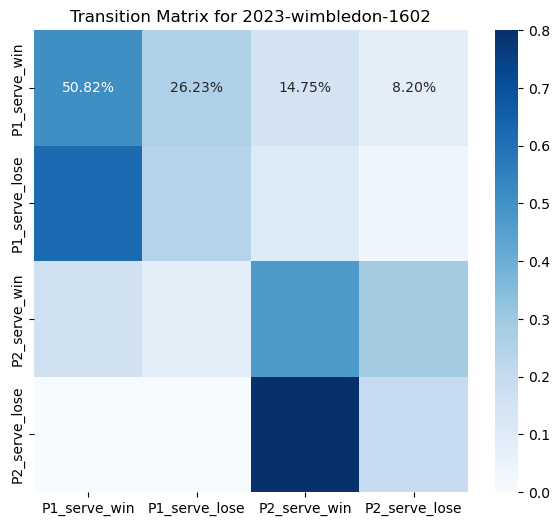

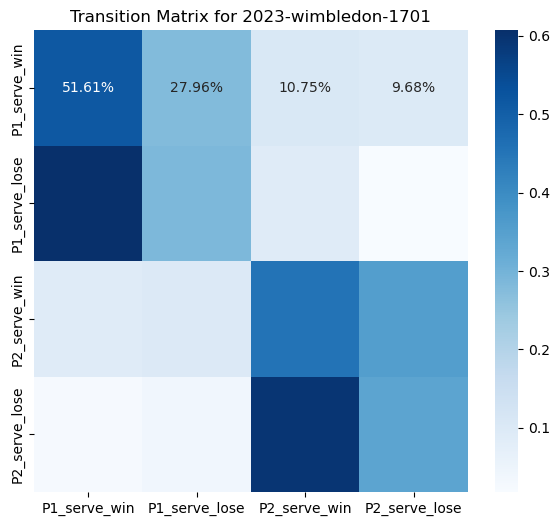

In [141]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Iterate over transition matrices
for i, transition_matrix in enumerate(transition_matrices):
    # Create a new figure for each matrix
    plt.figure(figsize=(7, 6))

    # Create a heatmap
    sns.heatmap(transition_matrix, annot=True, fmt=".2%", cmap='Blues', annot_kws={"size": 10})

    # Add a title using the value of match[id]
    plt.title(f'Transition Matrix for {match[i]}')

    # Show the plot
    plt.show()

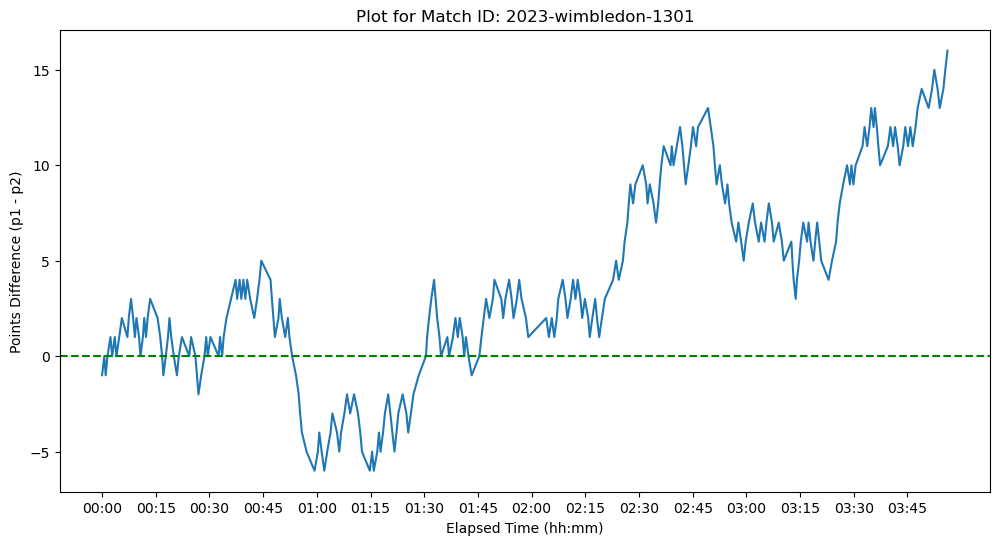

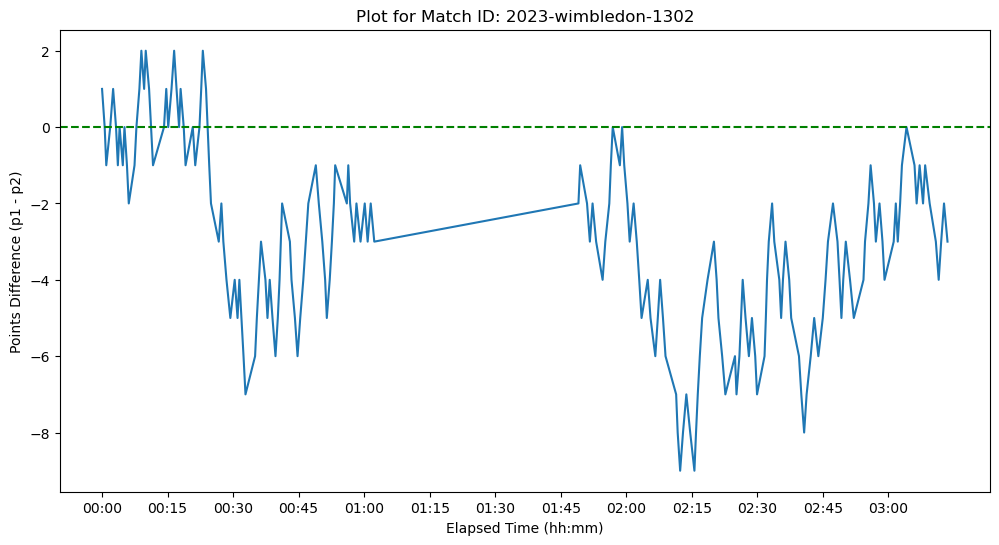

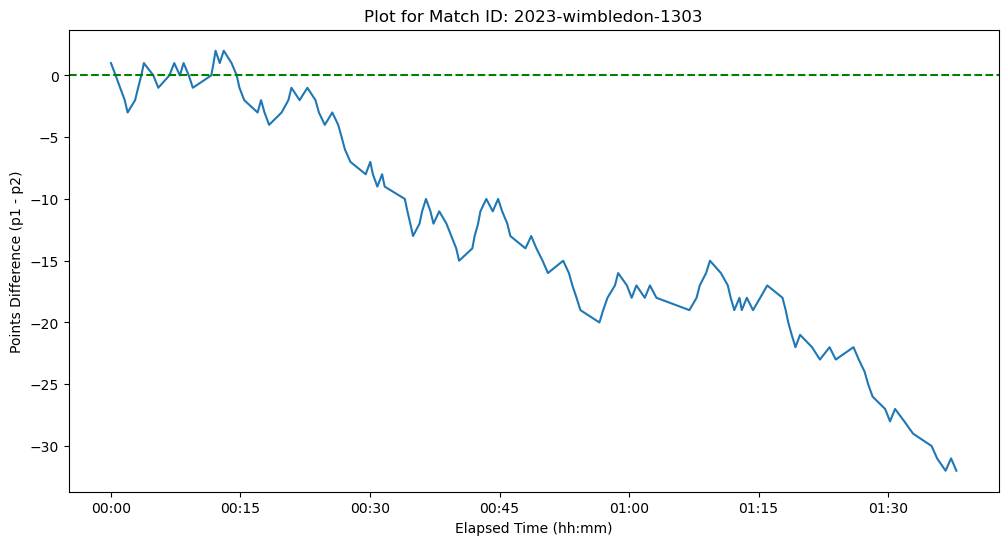

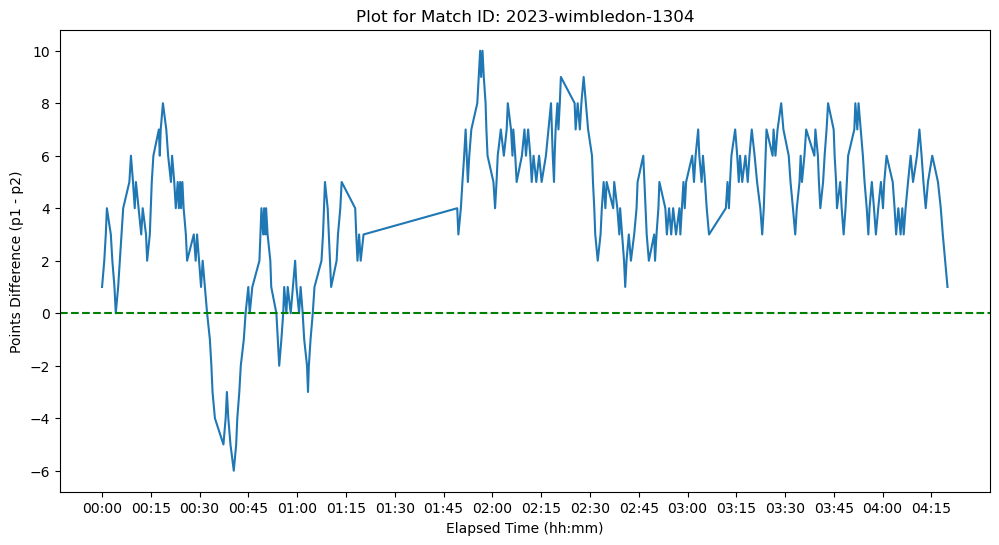

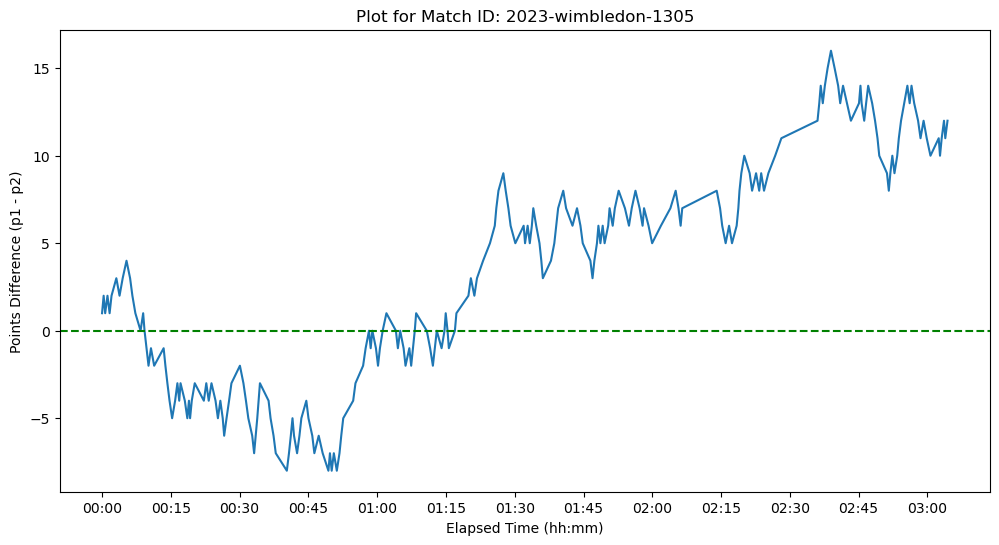

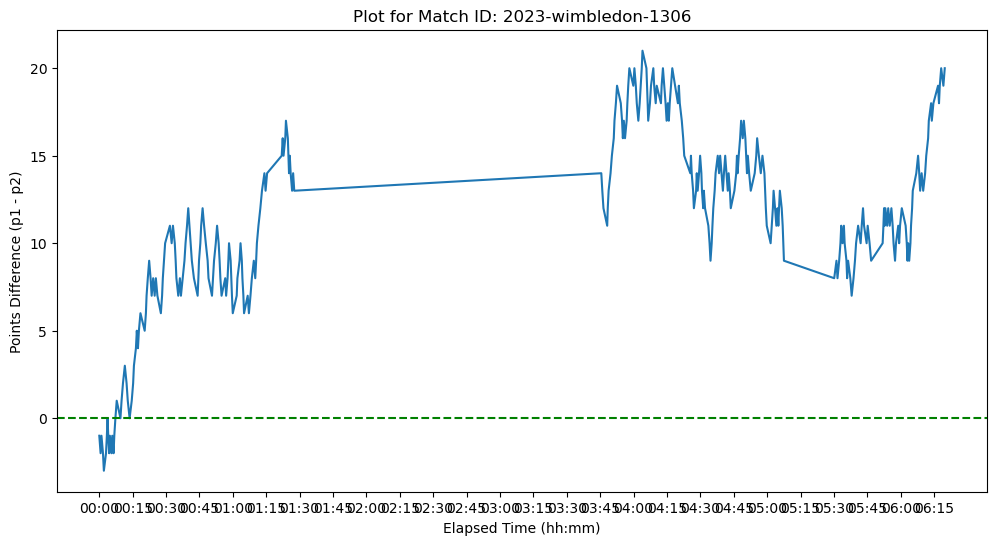

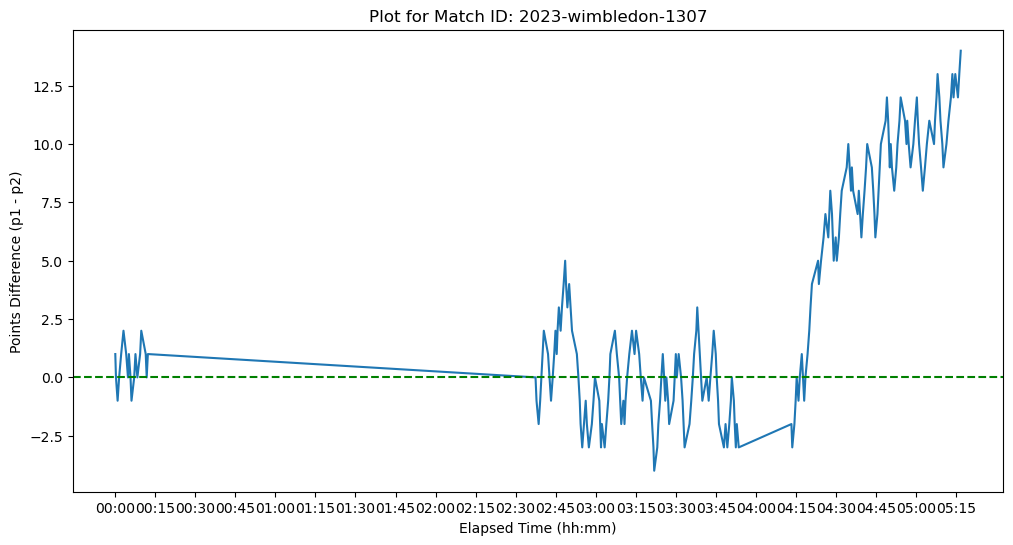

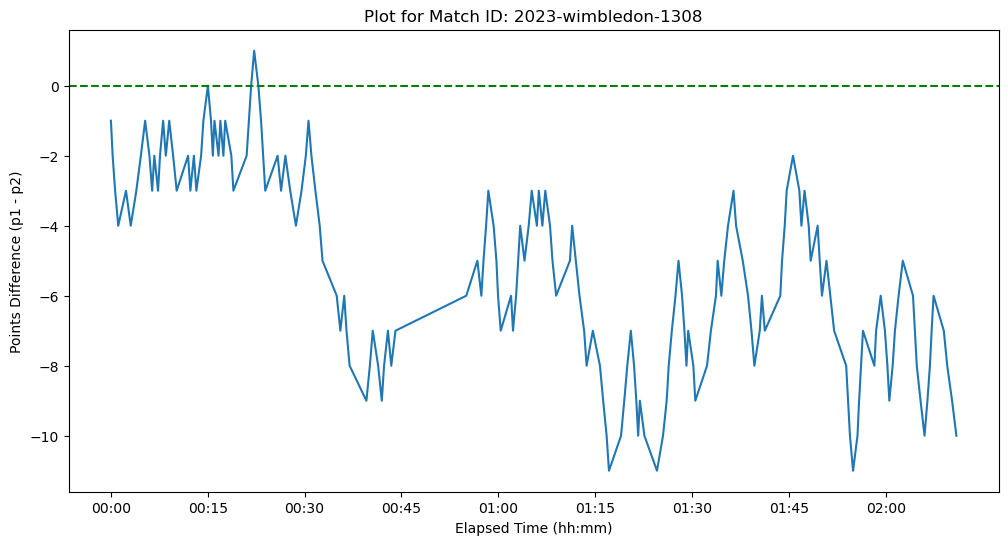

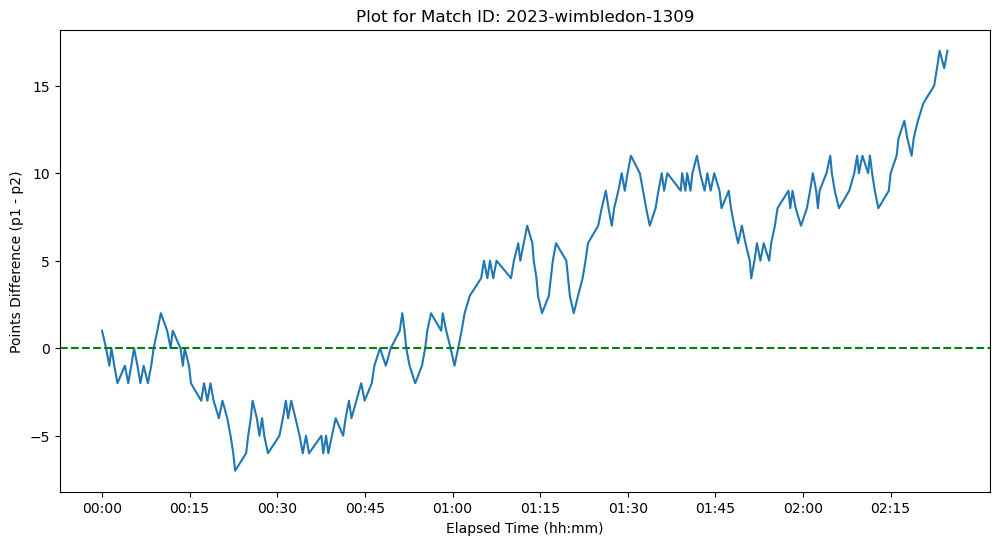

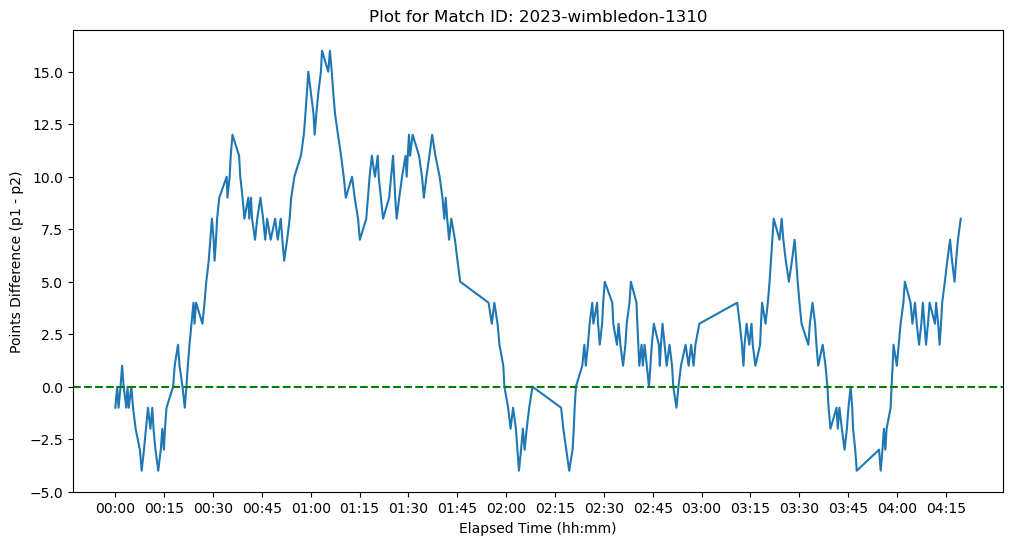

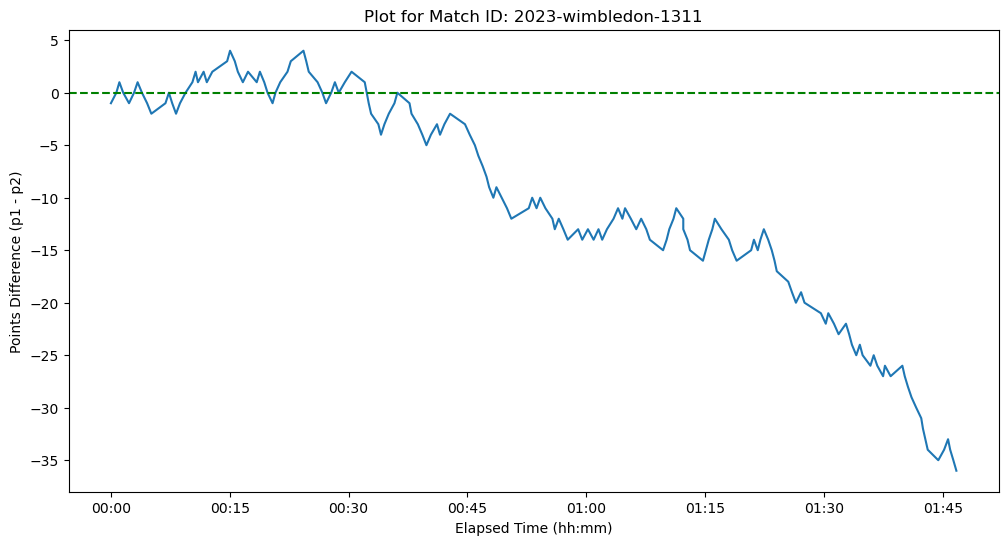

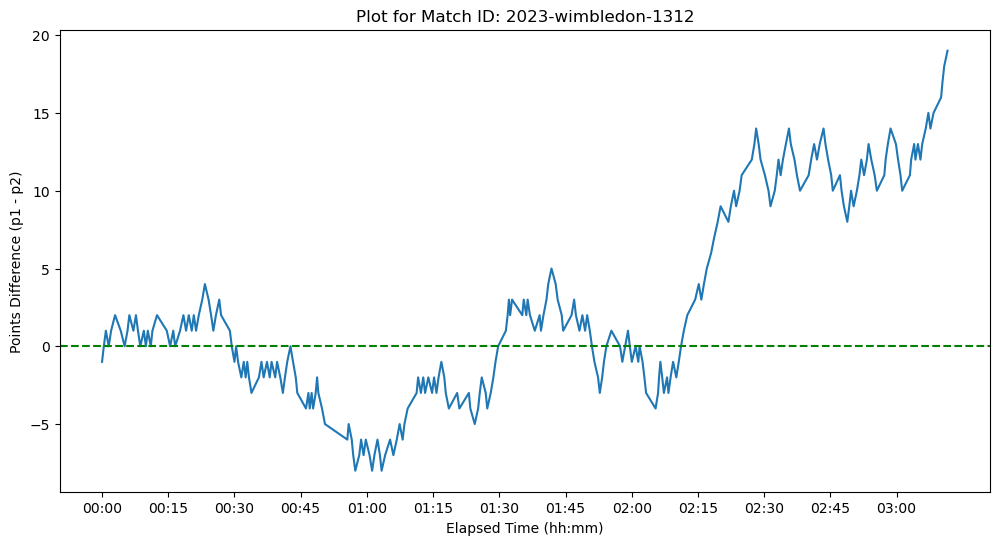

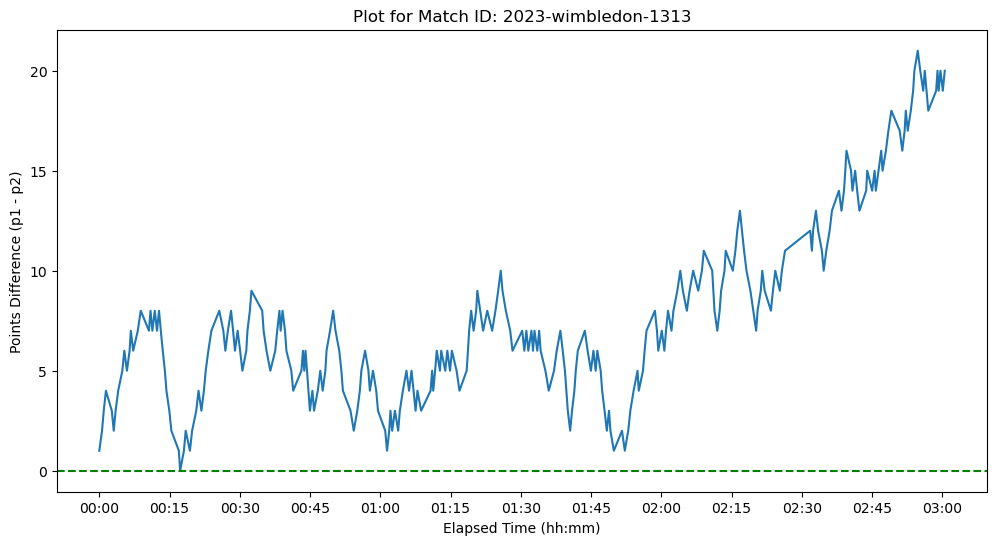

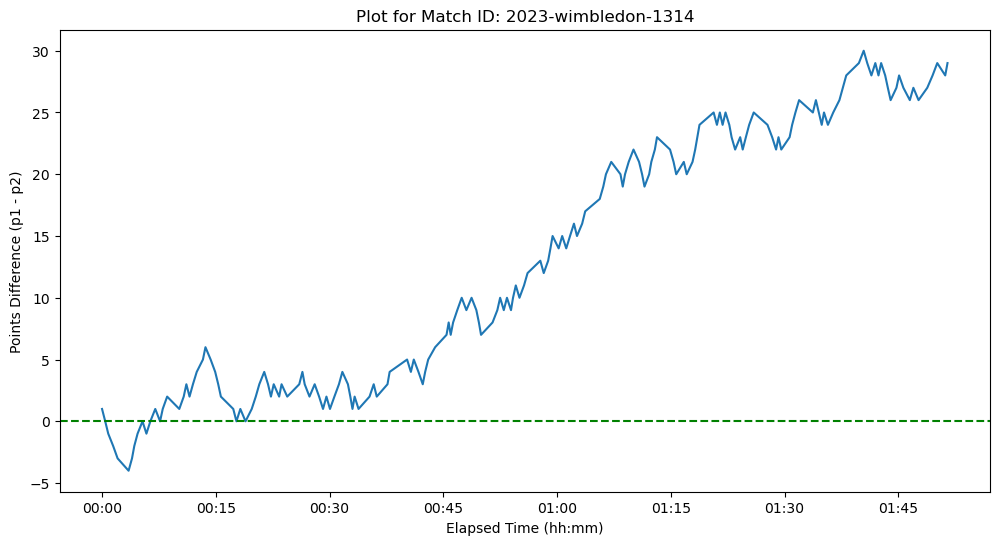

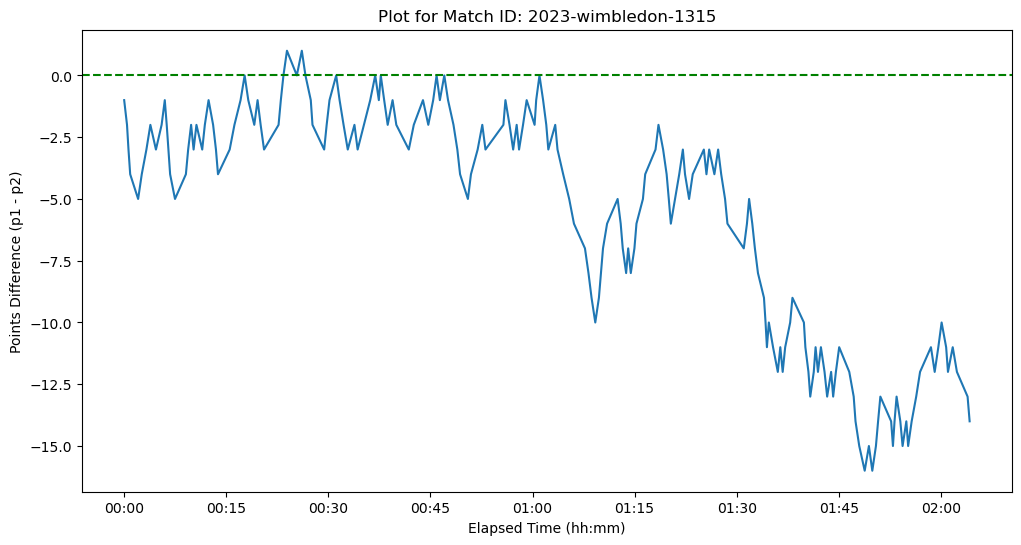

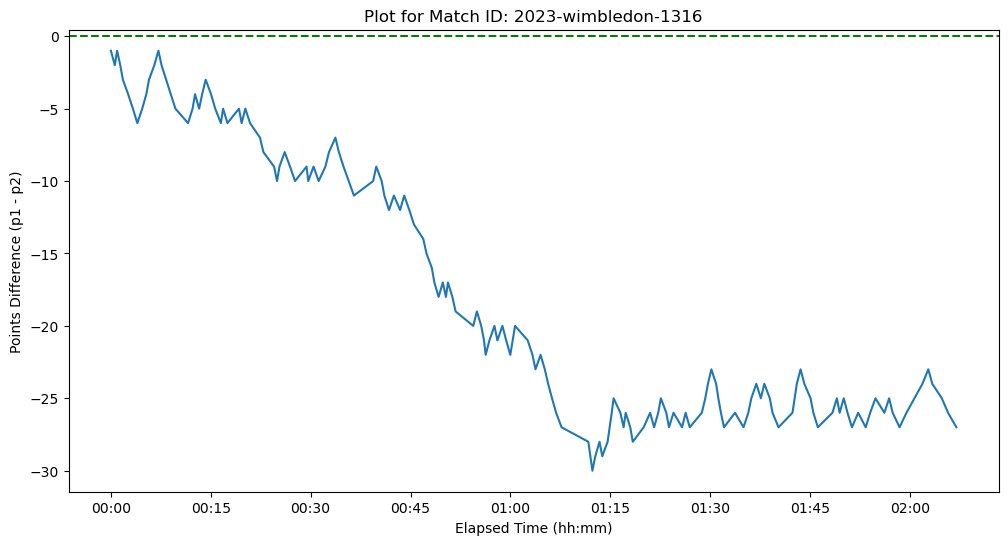

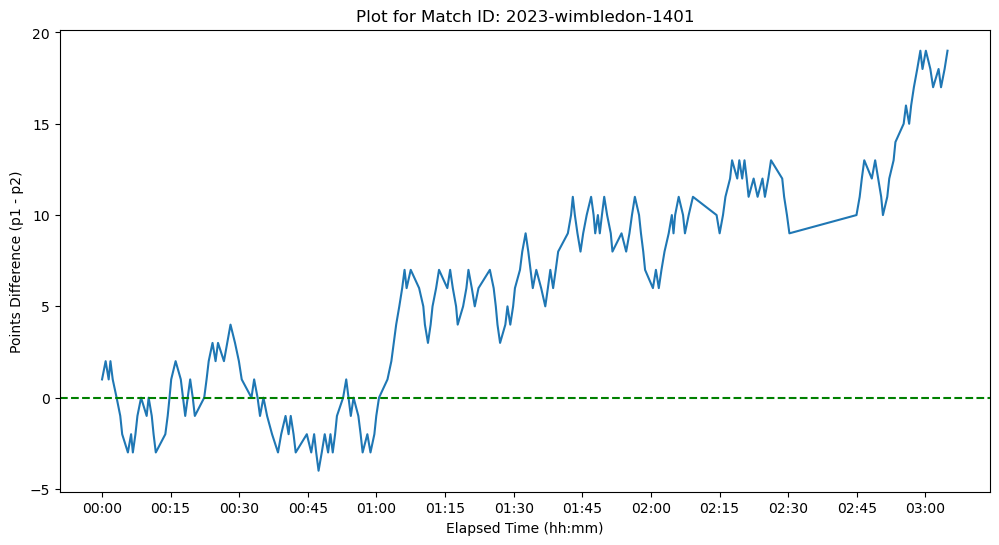

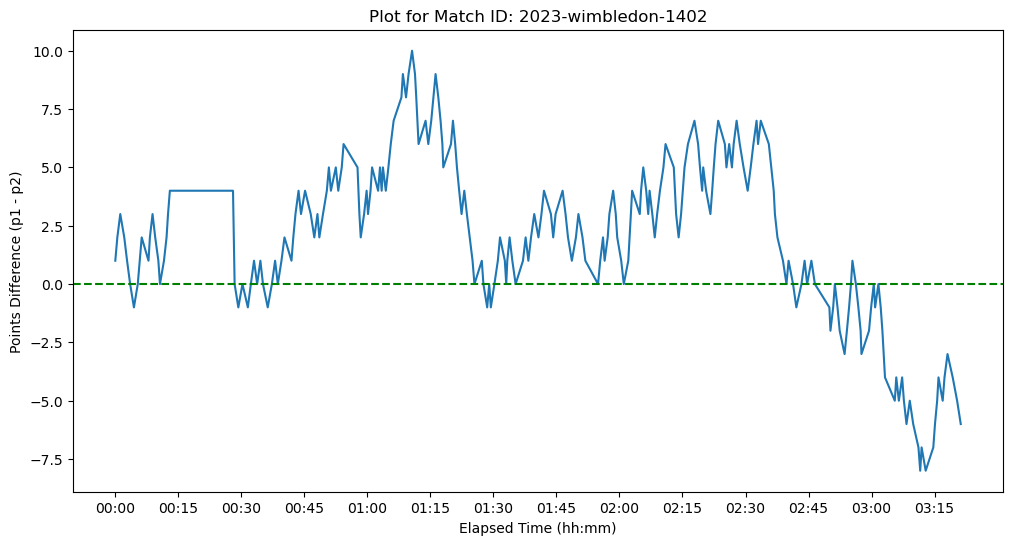

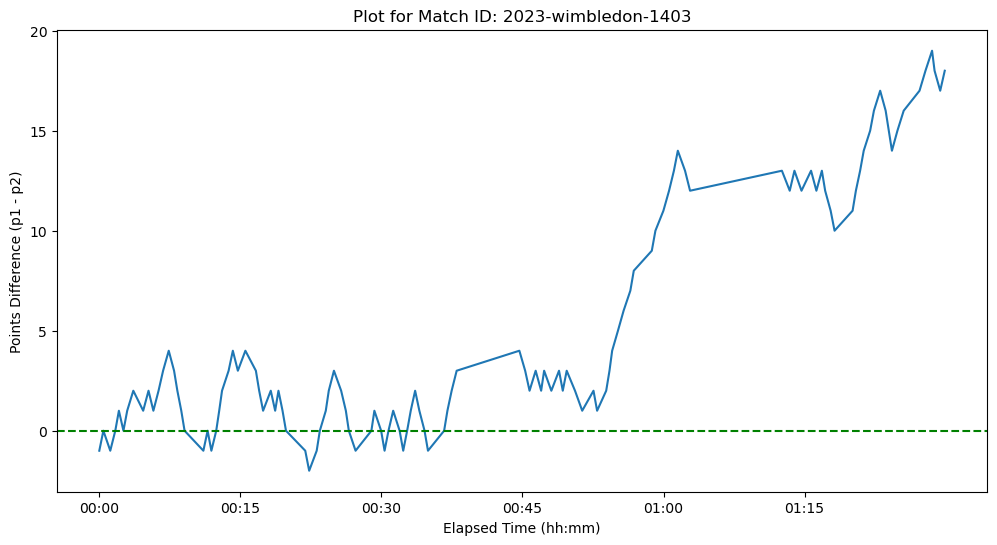

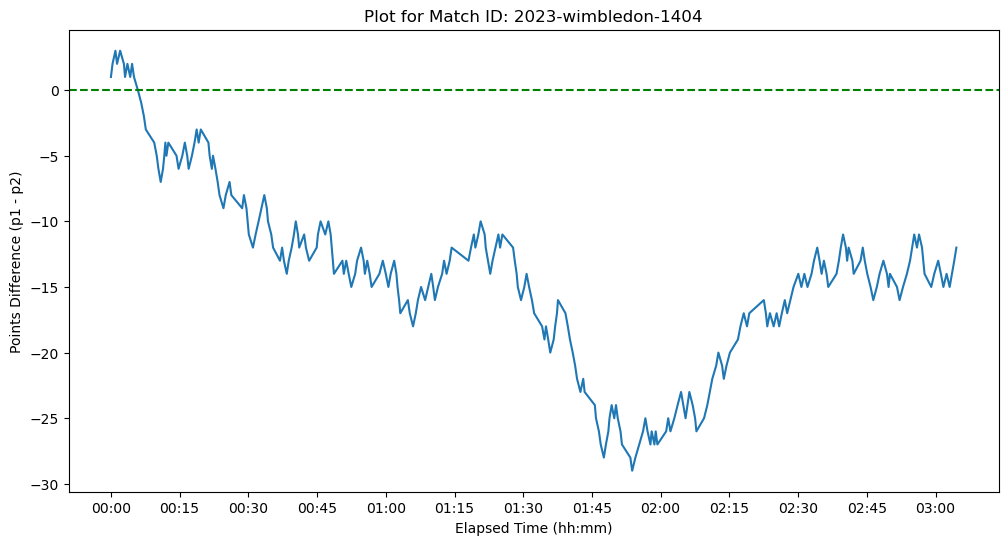

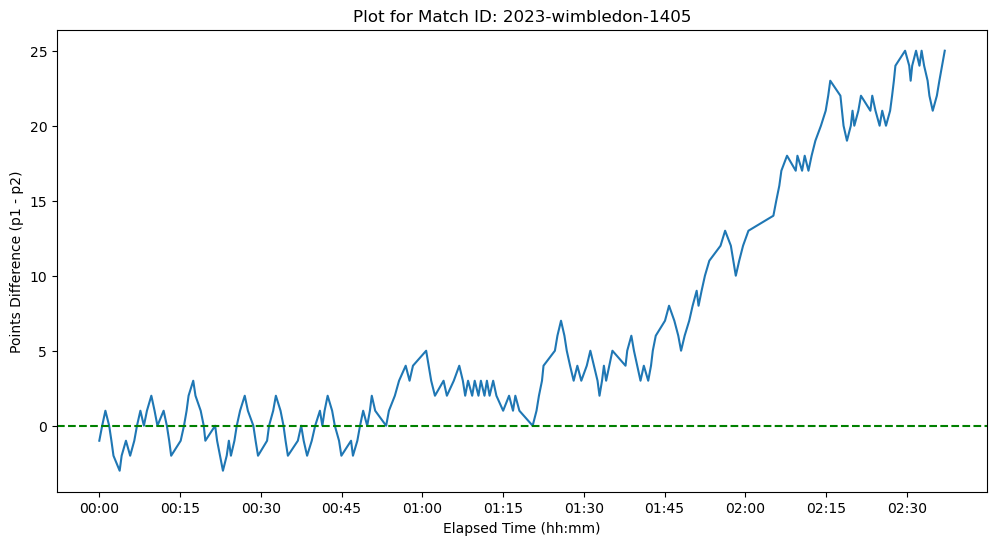

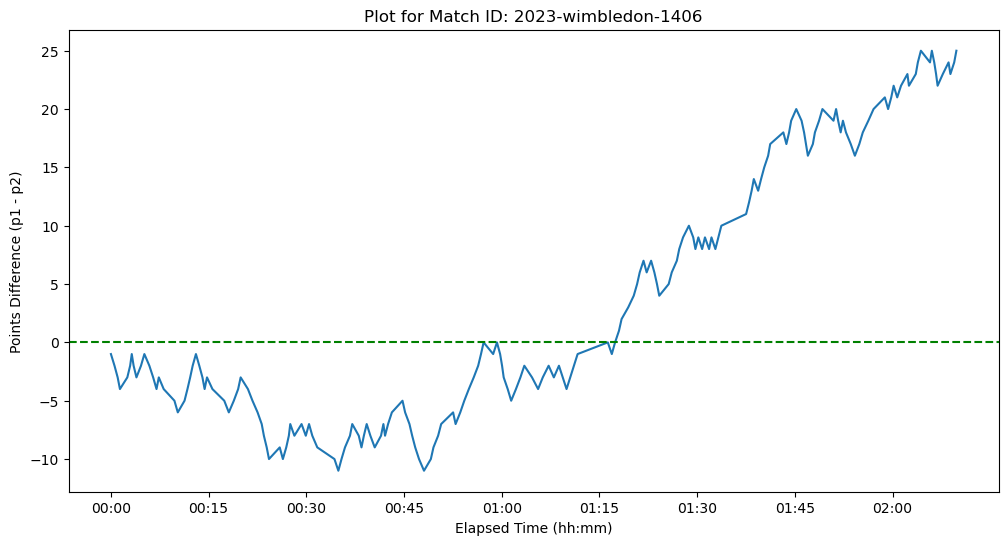

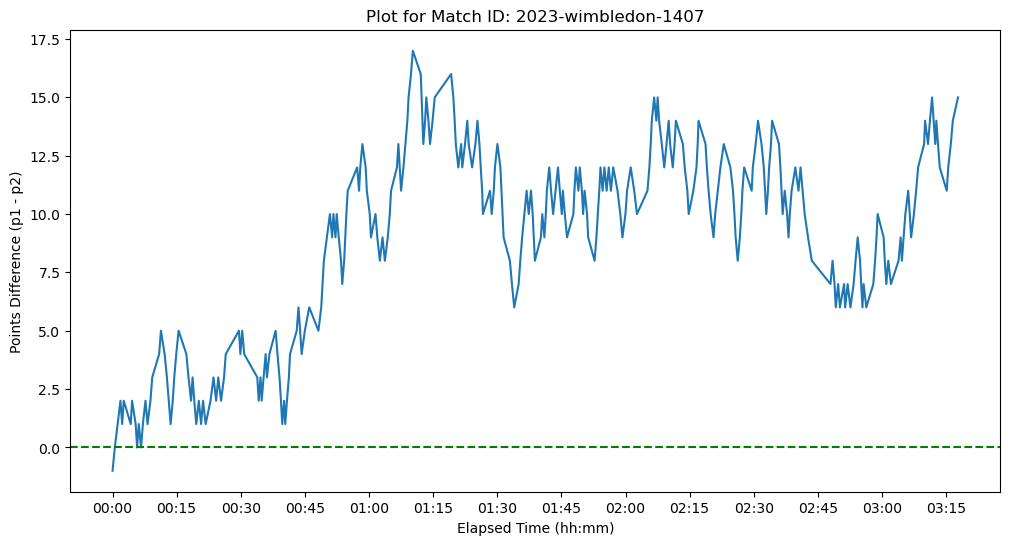

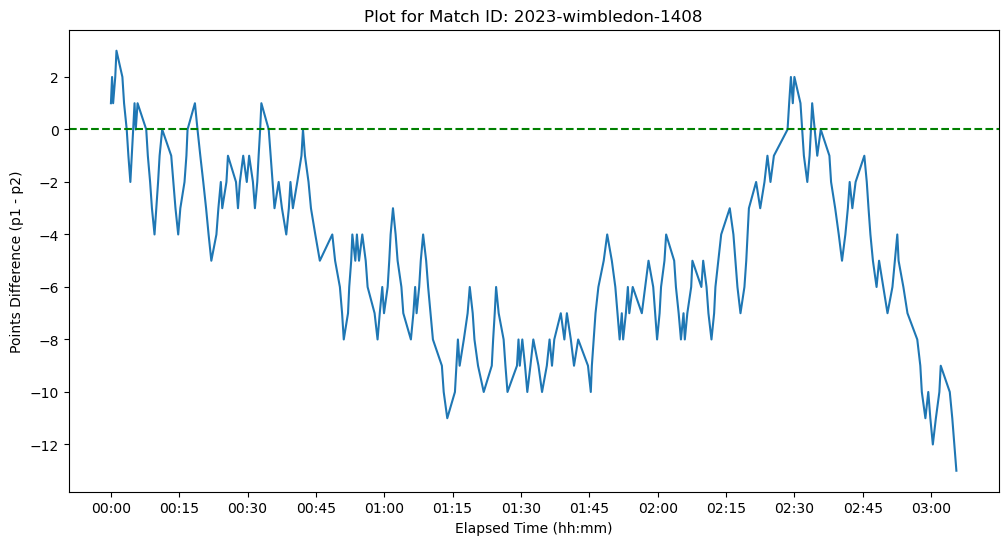

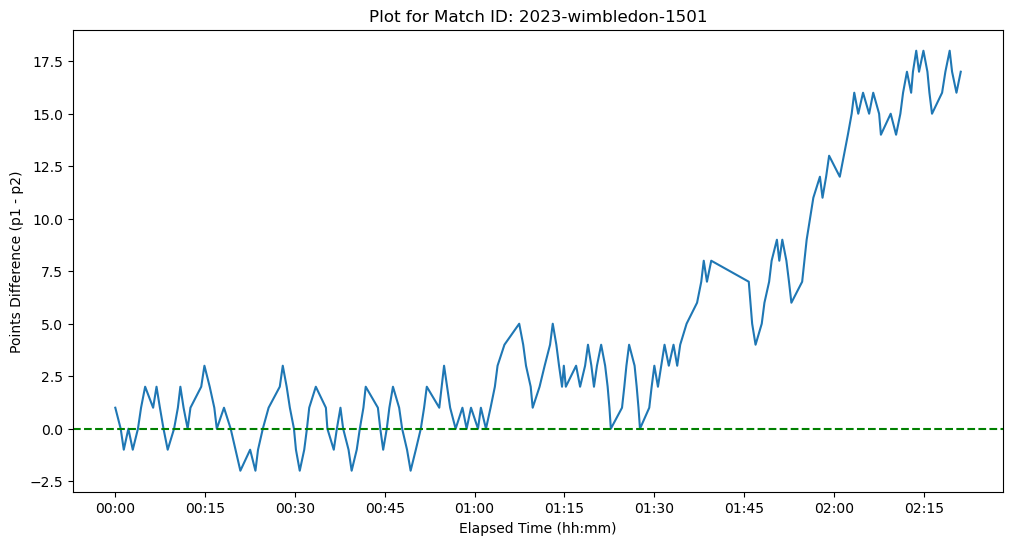

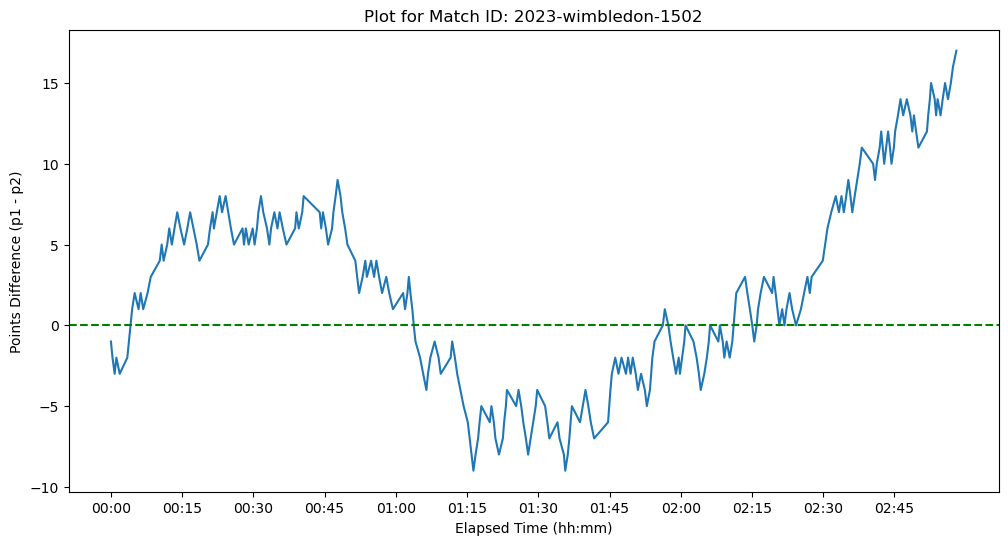

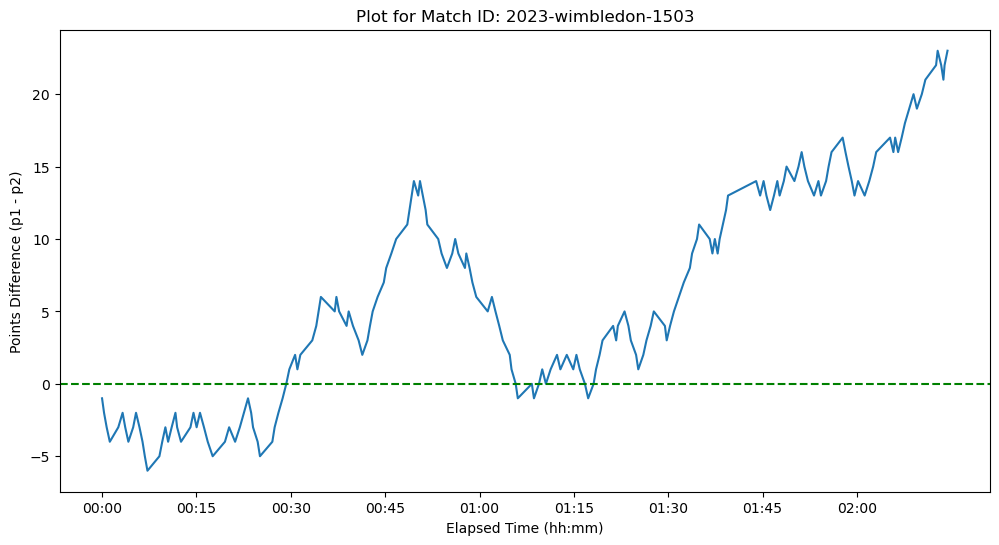

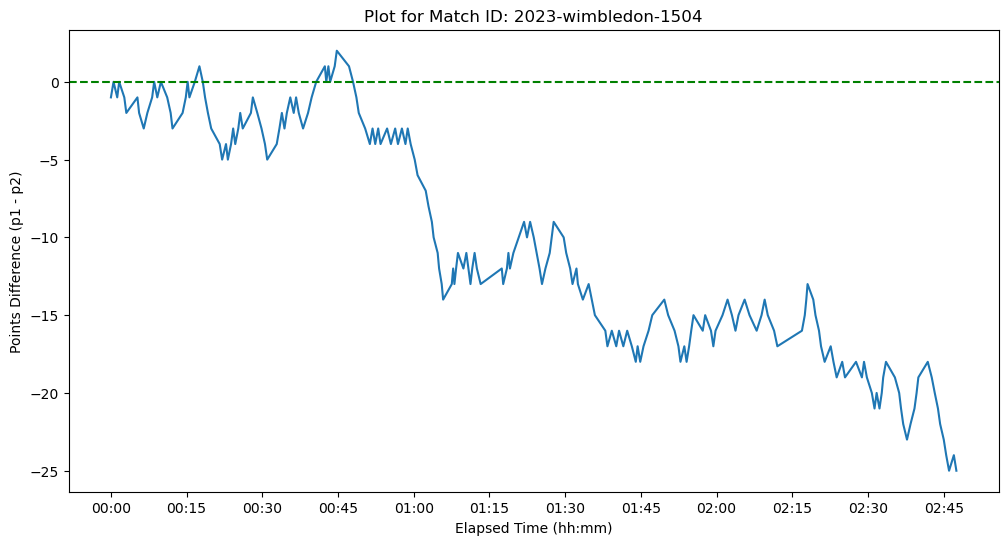

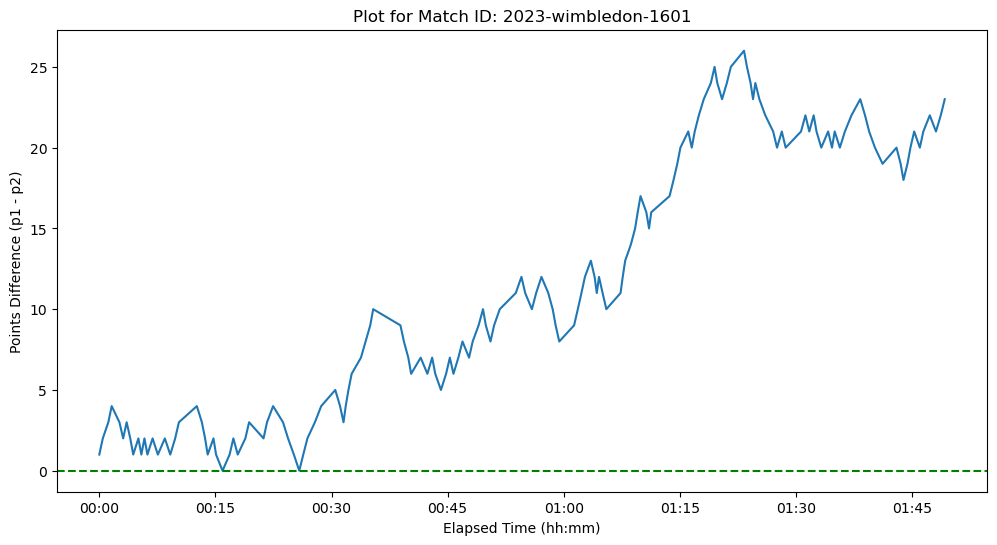

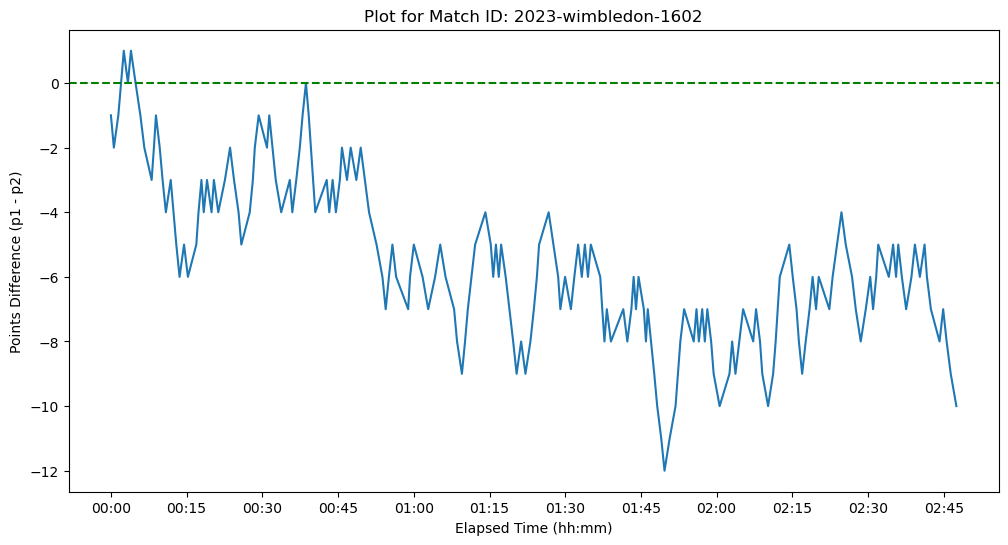

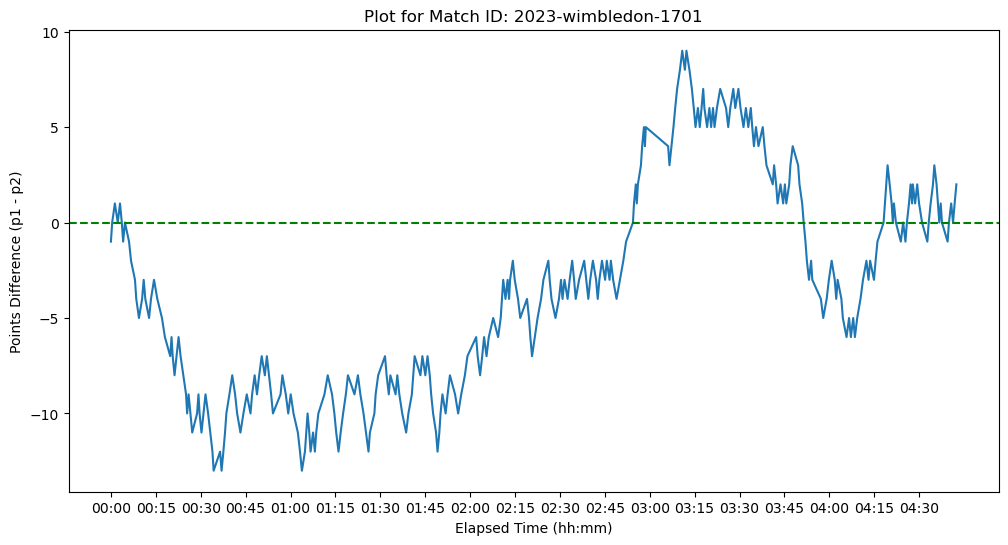

In [142]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def draw_plot(id, subdata):
        # Set the figure size (width, height)
    plt.figure(figsize=(12, 6))

    # Calculate the number of 1s subtracted by the number of 0s in 'point_victor'
    y_values = subdata[match[id]]['p1_points_won'] - subdata[match[id]]['p2_points_won']


    #print(y_values)
    # Get the 'elapsed_time' values and convert them to total number of seconds
    x_values = subdata[match[id]]['elapsed_time'].dt.total_seconds()
    #print(x_values)
    # Create the bar plot
    plt.plot(x_values, y_values)

    # Create xticks every 15 minutes
    x_ticks = np.arange(min(x_values), max(x_values), 15*60)  # 15 minutes in seconds
    x_tick_labels = [(datetime.min + timedelta(seconds=s)).time().strftime('%H:%M') for s in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

        # Add x and y labels
    plt.xlabel('Elapsed Time (hh:mm)')
    plt.ylabel('Points Difference (p1 - p2)')

        # Add a title
    plt.title(f'Plot for Match ID: {match[id]}')

    # Add a horizontal line at y=0
    plt.axhline(0, color="green", linestyle='--')

    # Show the plot
    plt.show()

# Usage:
for id in range(len(match)):
    #print(id)
    draw_plot(id, subdata)


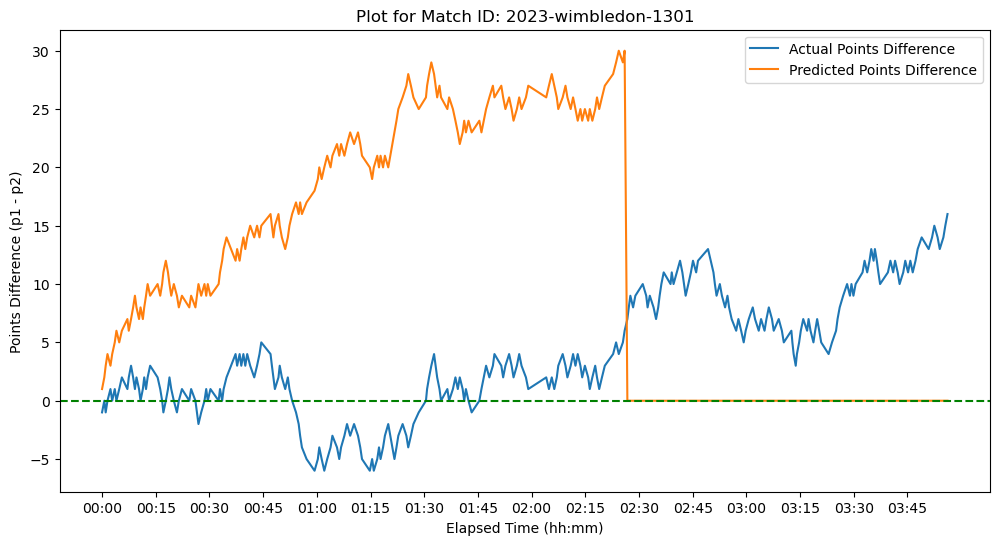

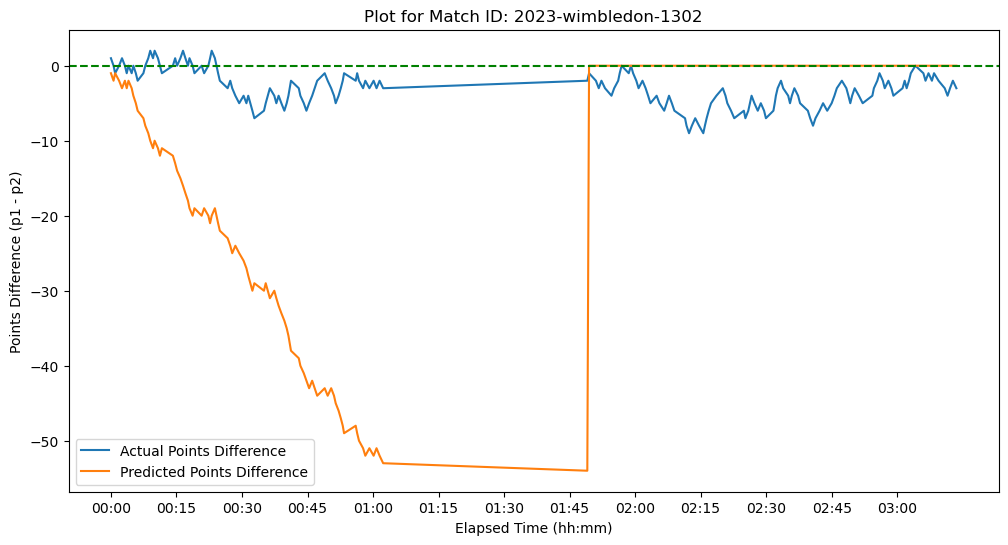

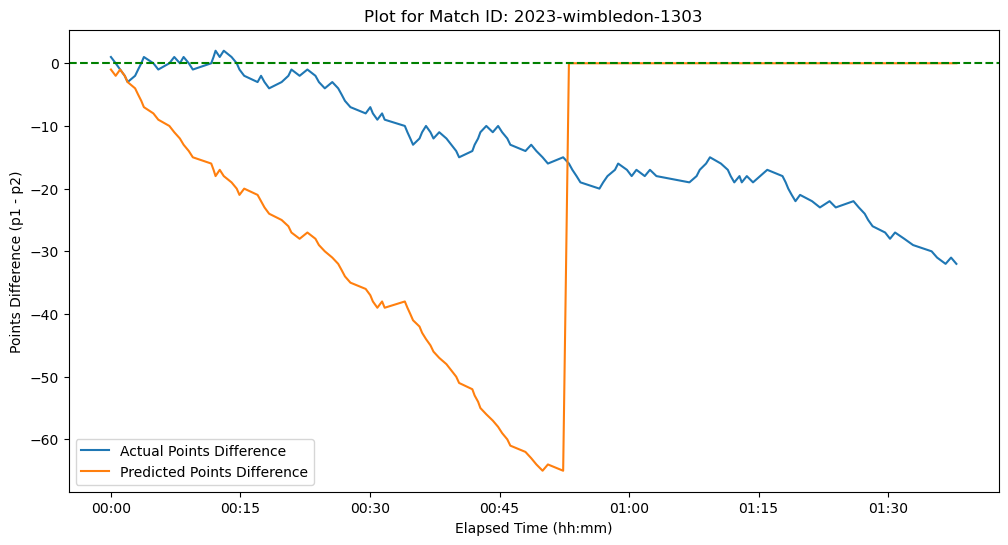

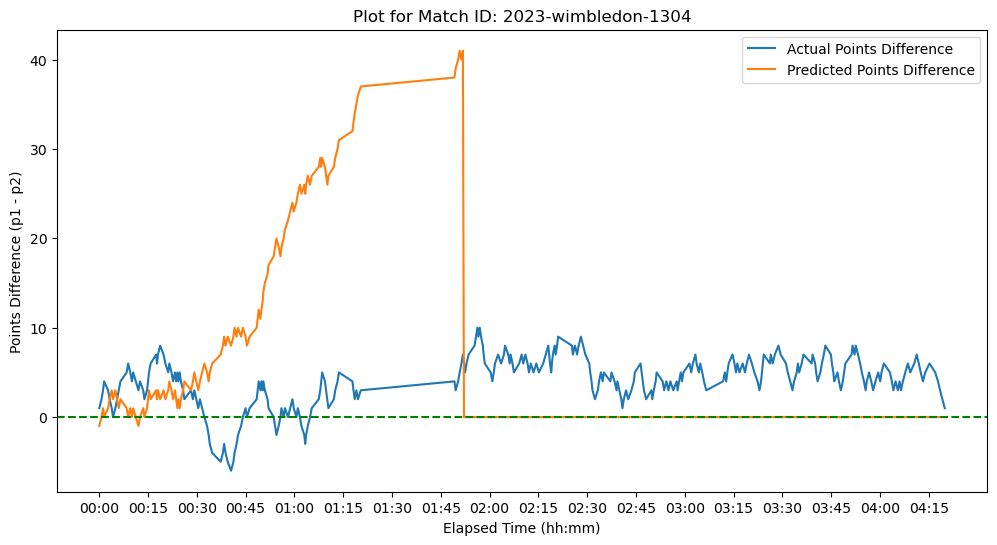

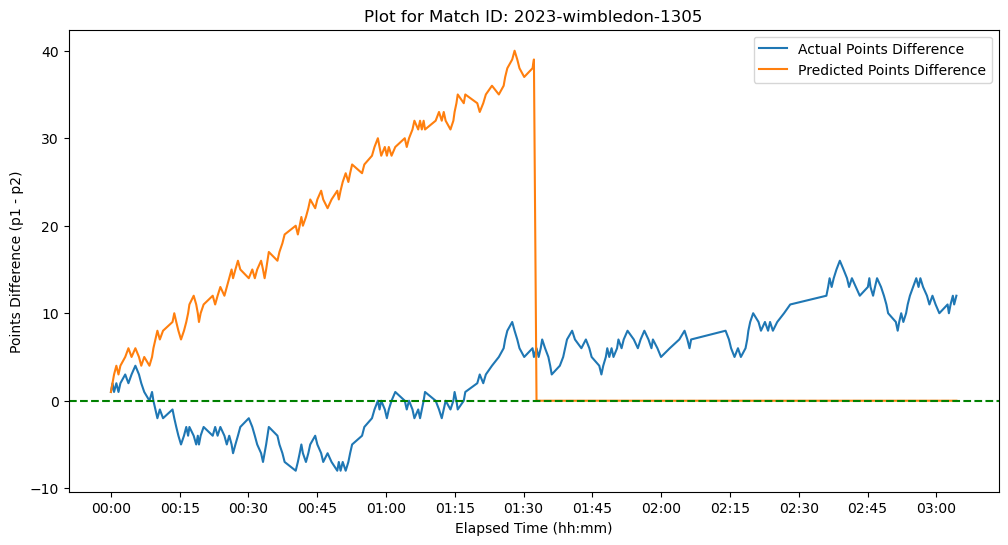

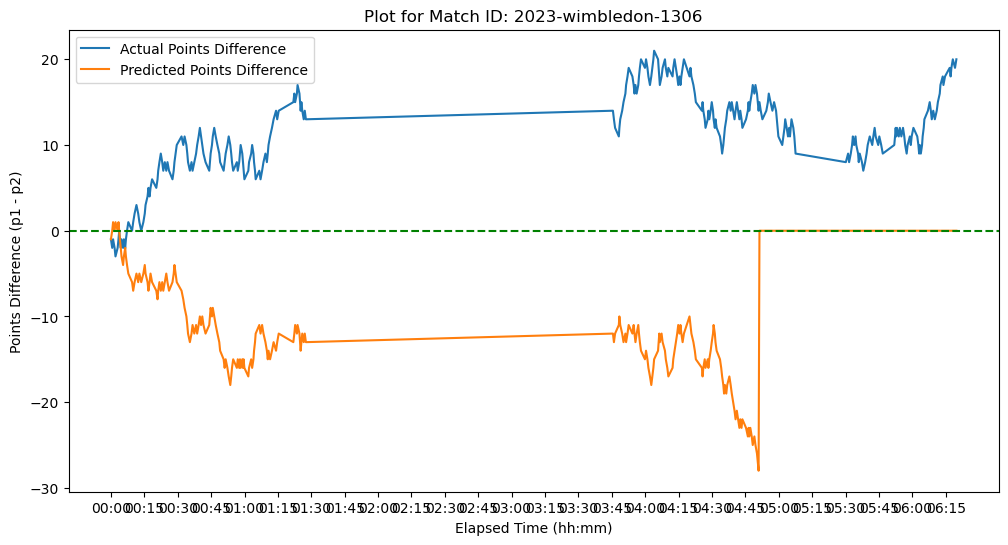

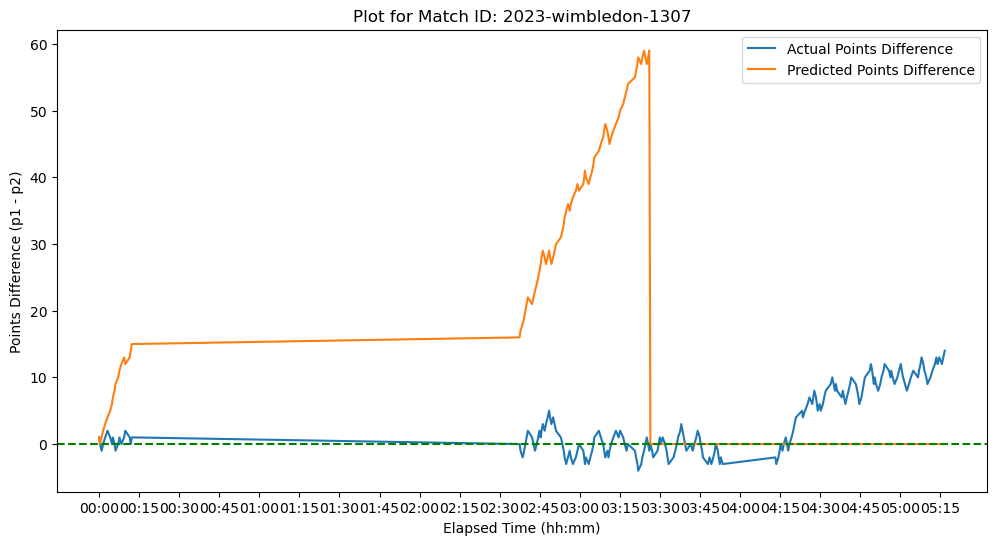

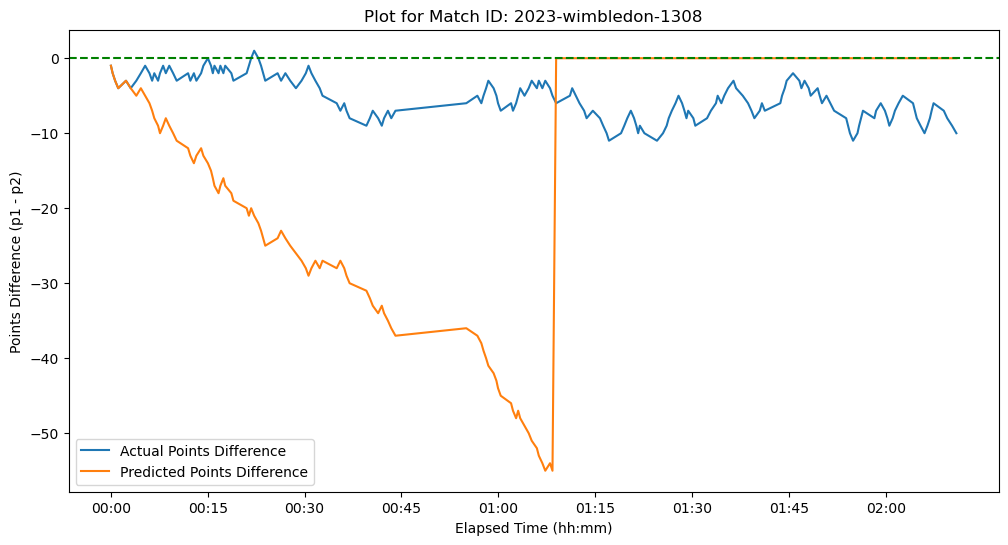

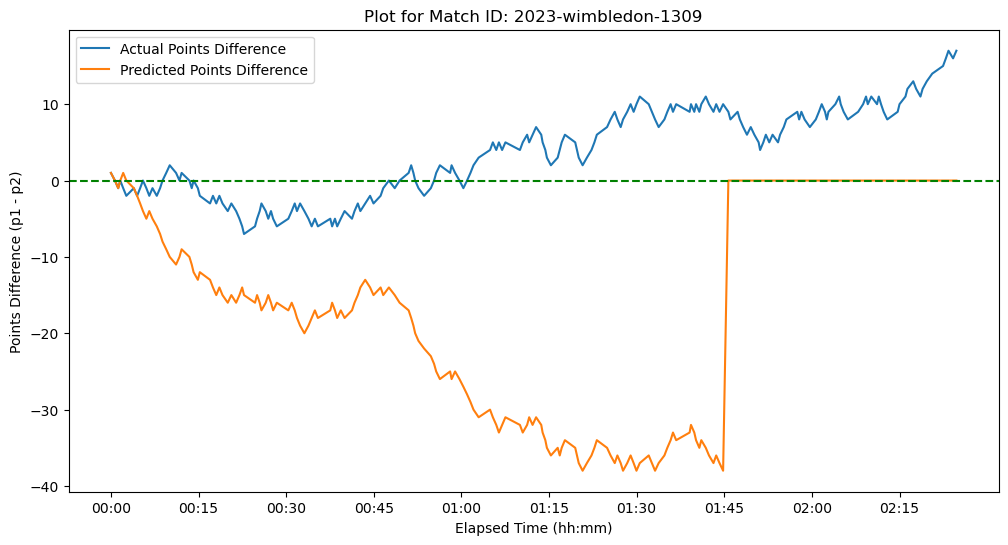

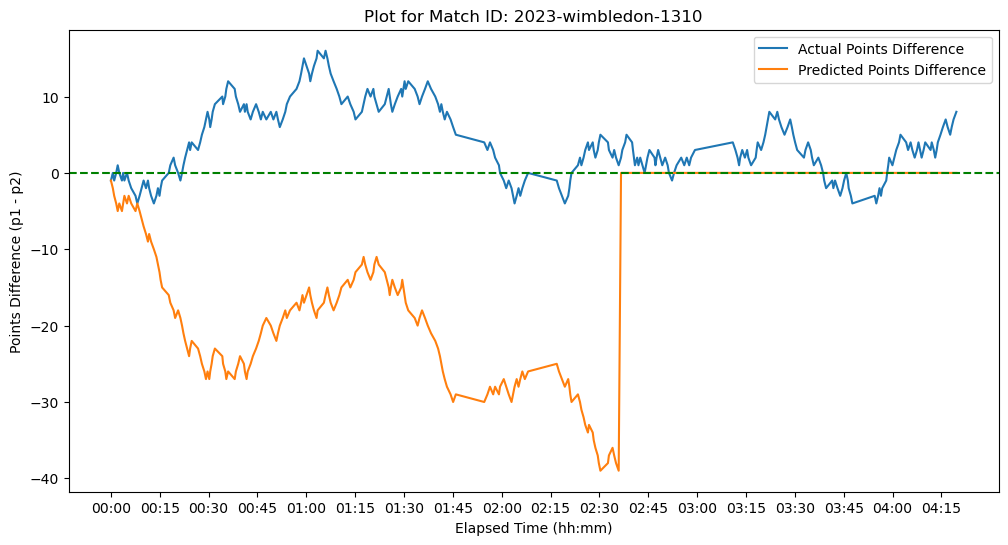

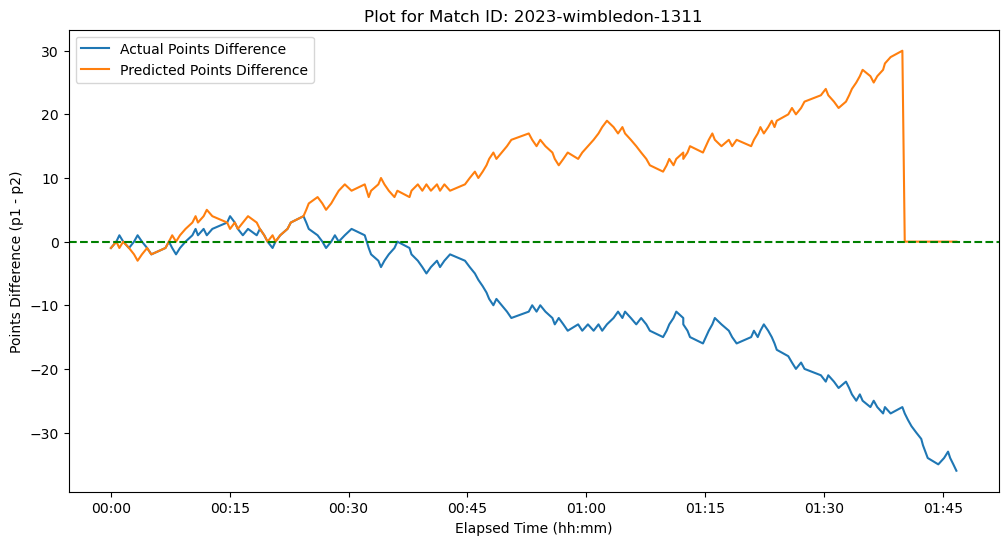

ValueError: index can't contain negative values

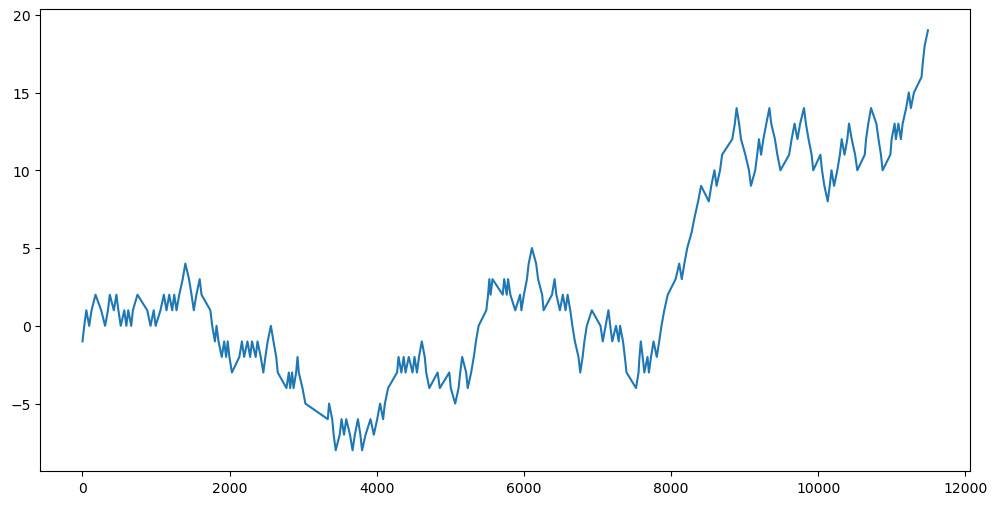

In [143]:
def draw_plot(id, subdata, predict_p1_point_win_list, predict_p2_point_win_list):
    # Set the figure size (width, height)
    plt.figure(figsize=(12, 6))

    # Calculate the number of 1s subtracted by the number of 0s in 'point_victor'
    y_values = subdata[match[id]]['p1_points_won'] - subdata[match[id]]['p2_points_won']

    # Get the 'elapsed_time' values and convert them to total number of seconds
    x_values = subdata[match[id]]['elapsed_time'].dt.total_seconds()

    # Create the bar plot
    plt.plot(x_values, y_values, label='Actual Points Difference')

    # Add the predicted points difference
    predicted_y_values = np.array(predict_p1_point_win_list[id]) - np.array(predict_p2_point_win_list[id])
    predicted_y_values = np.pad(predicted_y_values, (0, len(x_values) - len(predicted_y_values)), 'constant')
    plt.plot(x_values, predicted_y_values, label='Predicted Points Difference')

    # Create xticks every 15 minutes
    x_ticks = np.arange(min(x_values), max(x_values), 15*60)  # 15 minutes in seconds
    x_tick_labels = [(datetime.min + timedelta(seconds=s)).time().strftime('%H:%M') for s in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    # Add x and y labels
    plt.xlabel('Elapsed Time (hh:mm)')
    plt.ylabel('Points Difference (p1 - p2)')

    # Add a title
    plt.title(f'Plot for Match ID: {match[id]}')

    # Add a horizontal line at y=0
    plt.axhline(0, color="green", linestyle='--')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

# Usage:
for id in range(len(match)):
    draw_plot(id, subdata, predict_p1_point_win_list, predict_p2_point_win_list)